In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numbers import Number
from typing import Optional, Any
from numpy.typing import ArrayLike

from functools import reduce

In [3]:
def _df_colors(val: Any):
    '''Функция для более выделяющихся цветов в датафреймах'''
    
    if isinstance(val, bool) and val is False:
        color = "red"
    elif isinstance(val, bool) and val is True:
        color = "limegreen"
    elif isinstance(val, Number):
        # color = "gold"
        color = "mediumspringgreen"
    else:
        color = "cornflowerblue"
    return "color: %s" % color

In [4]:
def cols2drop(corr_df, threshold=0.9) -> list[str]:
    '''Функия для определения слишком коррелирующих признаков'''
    corr_df = corr_df.abs()
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    tri_corr = corr_df.mask(mask)
    to_drop = [c for c in tri_corr.columns if any(tri_corr[c] > threshold)]
    return to_drop, mask

In [5]:
emo2num = {'С': 1,
           'О': 2,
           'Н': 3,
           'Ж': 4,
           'У': 5,
           'Р': 6,
           'Г': 7,
           'Б': 8,
           'З': 9,
           'В': 10}

num2emo = {val: key for key, val in emo2num.items()}

letter2emo = {
"Г": "грусть",
"З": "злость",
"Р": "радость",
"У": "удивление",
"В": "волнение",
"Ж": "раздражение",
"Н": "недовольство",
"О": "обида",
"Б": "обречённость",
"С": "страх"
}

# ML

In [6]:
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay#, multilabel_confusion_matrix
from sklearn.inspection import permutation_importance

In [8]:
std_scaler = StandardScaler()

In [9]:
def print_metrics(y_preds: ArrayLike, 
                  y: ArrayLike, 
                  y_probs: Optional[ArrayLike] = None
) -> None:
    print(f'MSE: {mean_squared_error(y_preds, y)}')
    print(f"Accuracy: {accuracy_score(y_preds, y)}")
    print(f"F-score: {f1_score(y, y_preds, average='weighted')}")
    if y_probs is not None: 
        print(f"ROC-AUC: {roc_auc_score(y, y_probs, multi_class='ovr')}")

In [10]:
def show_conf_matrx(y_real: ArrayLike, y_preds: ArrayLike, classes: ArrayLike, title: str="") -> None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title(title)
    cm_rfc = confusion_matrix(y_real, y_preds)
    disp_rfc = ConfusionMatrixDisplay(cm_rfc, 
                                      display_labels=[letter2emo[num2emo[klas]] for klas in classes])
    disp_rfc.plot(include_values=True, cmap="viridis", ax=ax, colorbar=True)

In [11]:
def show_roc_curves(y_train: ArrayLike, y_test: ArrayLike, y_score: ArrayLike, classes: ArrayLike) -> None:
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    fig, axs = plt.subplots(ncols=5,
                            nrows=2, 
                            figsize=(25, 10))
    for class_of_interest, axis in zip(classes, axs.flatten()):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{letter2emo[num2emo[class_of_interest]]} vs the rest",
            color="darkorange",
            plot_chance_level=True,
            ax=axis
        )
        _ = display.ax_.set(
            xlabel="",
            ylabel="",
            # title="One-vs-Rest ROC curves",
        )

In [12]:
def show_feature_importances(importances: ArrayLike, feature_names: ArrayLike, title: str, size=(6,6)) -> None:
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    sorted_importance = importances_df.sort_values(by='Importance', ascending=False)
    sorted_importance = sorted_importance[sorted_importance != 0]
    # fig, ax = plt.subplots(figsize=(10,6))
    plt.figure(figsize=size)
    plt.barh(sorted_importance['Feature'], sorted_importance['Importance'])
    plt.title(title)

## Dataset

In [13]:
# собираем признаки, полученные в другом ноутбуке в большую признаковую матрицу
basic_metrics_DF = pd.read_csv("basic_metrics_DF.csv", index_col=0)
pos_DF = pd.read_csv("pos_DF.csv", index_col=0)
Ngrams_DF = pd.read_csv("Ngrams_DF.csv", index_col=0)
gramm_DF = pd.read_csv("gramm_DF.csv", index_col=0)
emotion_DF = pd.read_csv("emotion_DF.csv", index_col=0)
syntax_DF = pd.read_csv("syntax_DF.csv", index_col=0)
zipf_DF = pd.read_csv("zipf_DF.csv", index_col=0)

In [14]:
data_frames = [basic_metrics_DF, pos_DF, Ngrams_DF, gramm_DF, emotion_DF, syntax_DF, zipf_DF]

In [15]:
wholeDF = reduce(lambda left,right: pd.merge(left, right, how='outer'), data_frames)
wholeDF.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
1,0107635181_00__00-channel-0-number-005_22100,С,1,10,22,2,0.200000,2.200000,4.900000,1,0.100000,0.909091,0.000000,0.000000,0.000000,0.090909,0.272727,0.090909,0.000000,0.363636,0.454545,0.090909,0.333333,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.090909,0.000000,0.090909,0.090909,0.181818,0.181818,0.090909,0.000000,0.181818,0.090909,0.000000,0.000000,1,1,0,1,0,1,1,0,0,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,0,0,2,3,3,1
2,0107635181_00__00-channel-0-number-006_26690,С,1,11,17,0,0.000000,1.416667,3.583333,0,0.000000,0.916667,40.333333,247.933884,40.333333,0.416667,0.083333,0.166667,0.166667,0.083333,0.500000,0.333333,2.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.250000,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0,0,1,1,0,2,0,0,0,0,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,0,0,0,0,0,4,3,2,3
3,0107636961_00__00-channel-0-number-009_34800,С,1,7,15,1,0.125000,1.875000,4.125000,0,0.000000,0.875000,16.333333,612.244898,16.333333,0.000000,0.375000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,1,1,1,2,2,0
4,0107638181_00__00-channel-0-number-018_59400,С,1,5,11,1,0.200000,2.200000,4.800000,1,0.200000,0.833333,0.000000,0.000000,0.000000,0.166667

In [16]:
wholeDF = wholeDF.drop_duplicates(subset=["IDs"])
wholeDF.shape

(3498, 103)

In [17]:
wholeDF.describe().style.map(_df_colors)

,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,0,1,2,3,4,5,6,7,8
count,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000
mean,7.157233,7.434820,15.953688,0.890509,0.118074,2.021182,4.736755,0.548599,0.073352,0.923982,6.381209,389.845688,7.281426,0.244306,0.194304,0.177715,0.043288,0.191970,0.551548,0.221003,0.742405,0.040227,0.019396,0.004108,0.001493,0.002129,0.132594,0.017907,0.000291,0.030642,0.034276,0.108775,0.083814,0.002297,0.015220,0.024574,0.014528,0.032146,0.020770,0.003590,0.008594,0.000060,0.000036,0.000515,0.000442,0.000210,3.351302,0.059949,0.009210,0.067147,0.016823,0.133034,0.027893,0.041693,0.067913,0.014212,0.051621,0.089713,0.053827,0.000852,0.002129,0.065752,0.079188,0.052601,0.119783,0.026301,0.289880,0.437679,0.117782,0.046312,0.318754,0.000572,0.016581,0.078902,0.301029,0.575472,1.608634,2.590051,2.264151,0.330475
std,3.188373,2.802917,6.537687,0.952859,0.132992,0.452713,1.131979,0.751747,0.105812,0.103023,14.168513,981.157282,14.018270,0.148956,0.132548,0.147957,0.085842,0.140352,0.195792,0.178996,0.883415,0.071032,0.050713,0.026044,0.016518,0.018603,0.120363,0.053294,0.005844,0.064609,0.109309,0.123608,0.098060,0.017548,0.047200,0.056658,0.044665,0.068148,0.068646,0.028950,0.039774,0.002527,0.002113,0.009075,0.008862,0.006402,6.720432,0.100865,0.040521,0.101082,0.052691,0.129638,0.061057,0.080855,0.094179,0.050504,0.086662,0.101008,0.089640,0.010998,0.018603,0.265701,0.287508,0.229583,0.350991,0.175396,0.554200,0.669383,0.356914,0.227189,0.573854,0.023908,0.134262,0.292027,0.551603,0.757873,1.263103,1.824760,1.732457,0.619013
min,1.000000,2.000000,2.000000,0.000000,0.000000,0.500000,2.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,11.000000,0.000000,0.000000,1.714286,4.000000,0.000000,0.000000,0.857143,0.000000,0.000000,0.000000,0.142857,0.1111

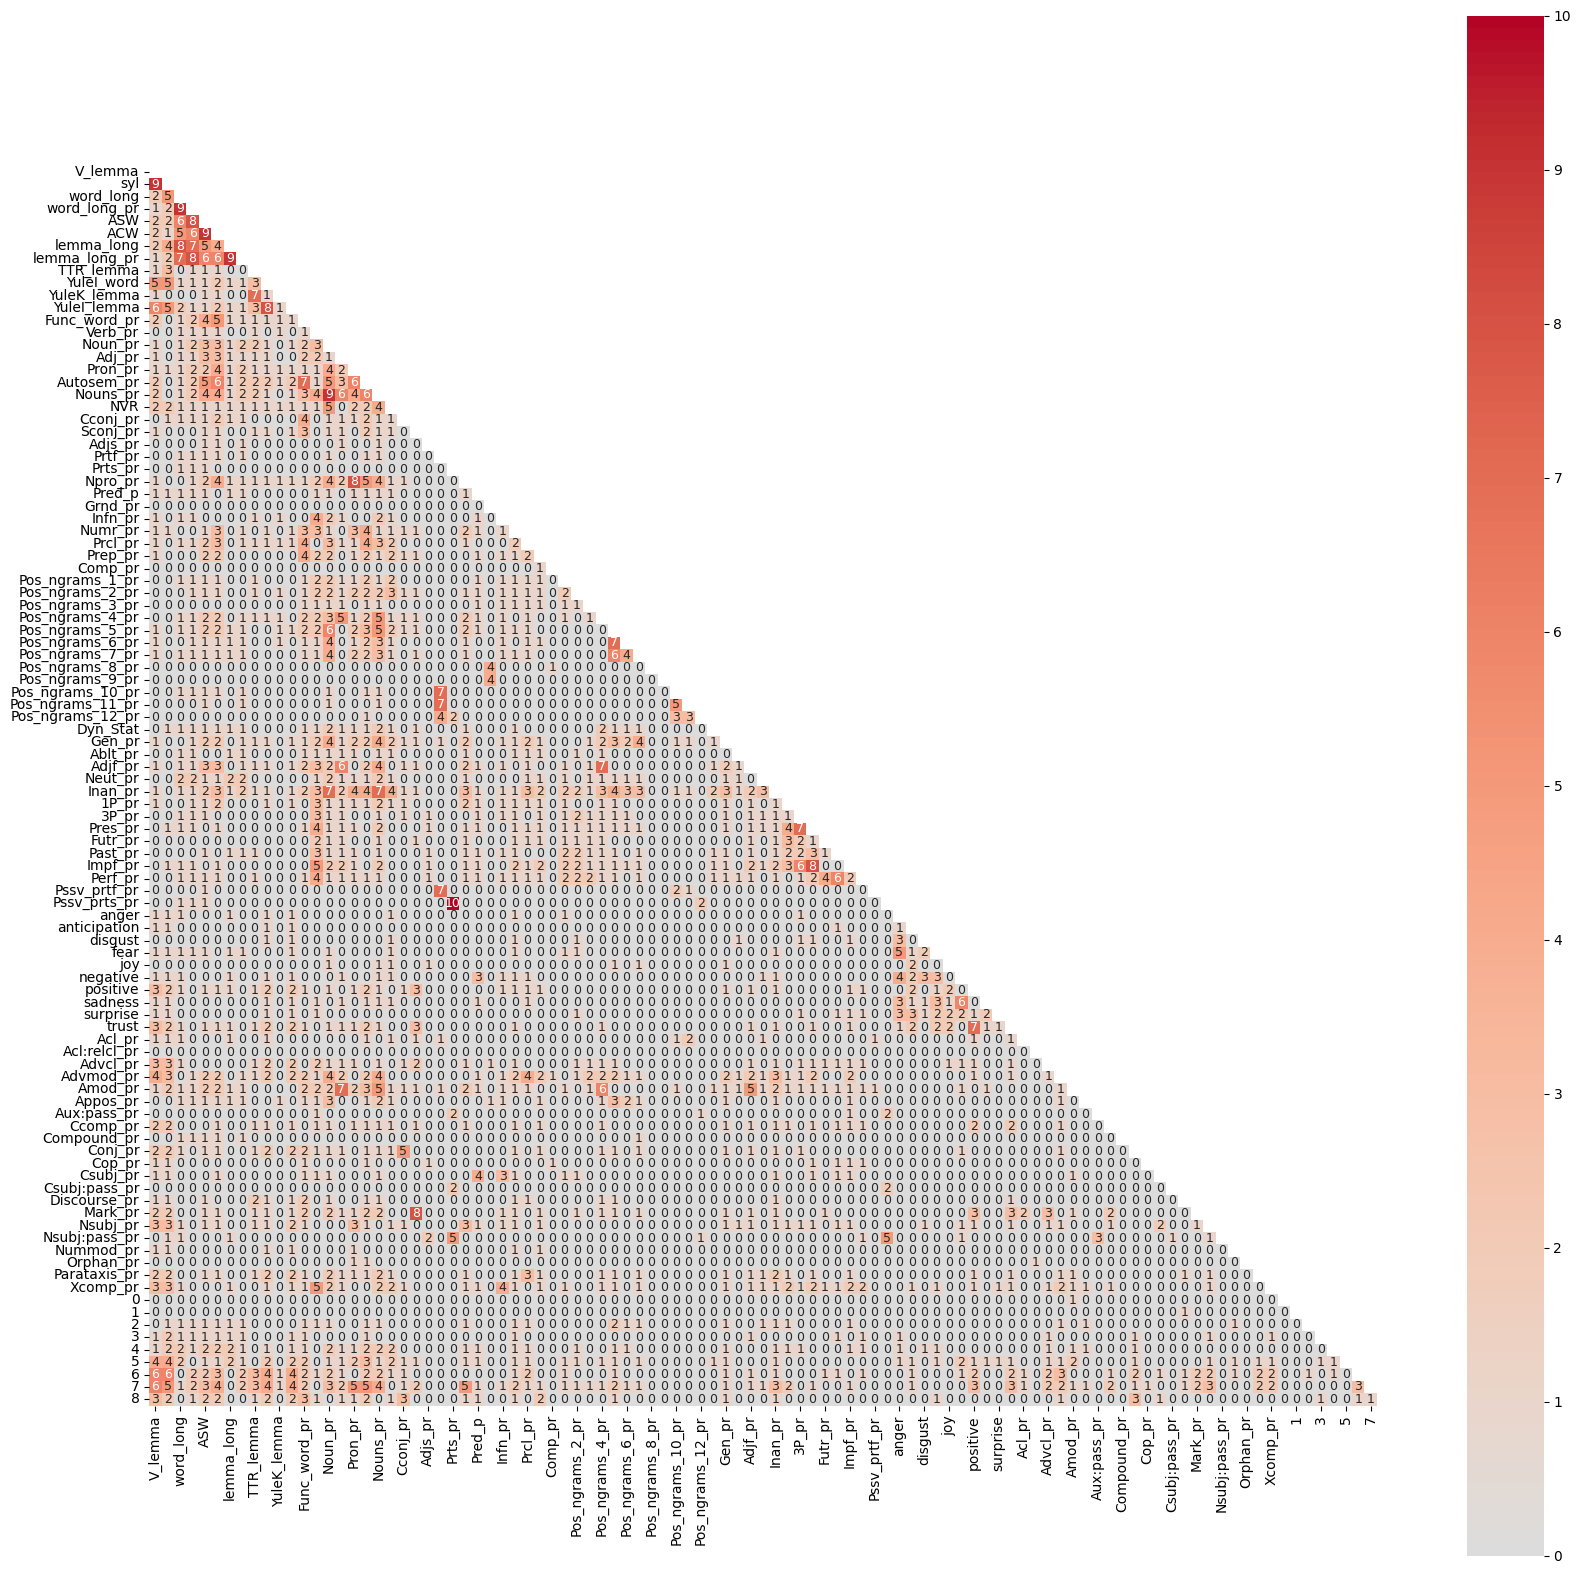

In [18]:
corr_whole = wholeDF[wholeDF.columns[3:]].corr(numeric_only=True)

drop_whole, mask_whole = cols2drop(corr_whole)

corr_whole = (corr_whole.abs() * 10).round()

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_whole,
    mask=mask_whole,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.001,
    annot=True,
    annot_kws={"size": 9},
    cbar_kws={"ticks": [i for i in range(10 + 1)]},
)
plt.savefig(
    r"C:\Users\Ivan\Desktop\AI\0_Dissertation\CorrHeatmapWhole.png", bbox_inches="tight"
)

In [19]:
drop_whole

['Prts_pr']

In [20]:
wholeDF = wholeDF.drop(drop_whole, axis=1)

In [21]:
wholeDF[wholeDF.columns[3:]] = std_scaler.fit_transform(wholeDF[wholeDF.columns[3:]])
wholeDF.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,-0.511976,-0.757821,-0.934699,-0.887960,-0.415000,-0.209181,-0.729870,-0.693324,0.737978,-0.450444,-0.397389,-0.519498,-0.521301,1.049052,1.051932,-0.504344,-0.180310,0.588051,0.627648,0.291631,-0.566402,-0.382525,-0.157769,-0.090390,-1.101779,-0.336044,-0.049876,-0.474333,-0.313618,-0.880123,0.845034,-0.130915,-0.322514,2.508260,-0.325305,1.974228,-0.302616,-0.124013,-0.216107,-0.023885,-0.016910,-0.056809,-0.049919,-0.032772,-0.349924,-0.594433,-0.227316,0.984686,-0.319326,1.545288,-0.456909,3.607456,2.818665,-0.281436,-0.595738,2.412246,-0.600571,-0.077452,-0.114444,-0.247501,-0.275469,-0.229150,-0.341319,-0.149972,-0.523135,-0.653947,-0.330047,-0.203878,-0.555541,-0.134329,-0.058671,2.547619,-1.427045,-0.450432,-0.175915,-0.058671,-0.205699,-0.016910,-0.435656,-0.194099,-0.262191,-0.033835,-0.269587,-0.409337,-1.671504,-0.134329,-0.115437,-0.050789,-0.425393,-0.573169,-0.023918,-0.123514,-0.270227,-0.545814,1.879909,-0.481925,-0.323405,-1.307088,1.081756
1,0107635181_00__00-channel-0-number-005_22100,С,1,0.915313,0.924972,1.164548,0.616108,0.395048,0.144233,0.600555,0.251882,-0.144567,-0.450444,-0.397389,-0.519498,-1.029965,0.591747,-0.586783,-0.504344,1.223285,-0.495506,-0.726904,-0.463123,0.713614,-0.382525,-0.157769,-0.090390,0.409021,-0.336044,-0.049876,-0.474333,-0.313618,-0.880123,-0.854840,-0.130915,-0.322514,-0.433789,1.710326,0.862406,-0.302616,-0.124013,-0.216107,-0.023885,-0.016910,-0.056809,-0.049919,-0.032772,-0.349924,-0.594433,-0.227316,0.235113,-0.319326,-0.324987,1.032227,1.733284,1.209630,1.518862,-0.595738,0.911995,0.413735,-0.077452,-0.114444,3.516671,3.203193,-0.229150,2.508167,-0.149972,1.281525,0.840179,-0.330047,-0.203878,1.187313,-0.134329,-0.058671,-0.392523,0.700749,-0.450432,-0.175915,-0.058671,-0.205699,-0.016910,-0.435656,-0.194099,-0.262191,-0.033835,-0.269587,-0.409337,0.598264,-0.134329,-0.115437,-0.050789,-0.425393,1.744686,-0.023918,-0.123514,-0.270227,-0.545814,-0.759434,0.309889,0.224691,0.424804,1.081756
2,0107635181_00__00-channel-0-number-006_26690,С,1,1.272135,0.160066,-0.934699,-0.887960,-1.335509,-1.019088,-0.729870,-0.693324,-0.071022,2.396651,-0.144658,2.358111,1.157289,-0.837333,-0.074685,1.437475,-0.774139,-0.263315,0.627648,1.423764,-0.566402,-0.382525,-0.157769,4.955213,-0.409329,-0.336044,-0.049876,-0.474333,-0.313618,-0.205854,1.694971,4.618698,-0.322514,-0.433789,-0.325305,0.751224,-0.302616,-0.124013,-0.216107,-0.023885,-0.016910,-0.056809,-0.049919,-0.032772,-0.498745,-0.594433,-0.227316,0.160156,-0.319326,0.259474,-0.456909,-0.515723,-0.721212,-0.281436,-0.595738,-0.888306,-0.600571,7.500797,-0.114444,-0.247501,-0.275469,4.127193,2.508167,-0.149972,3.086184,-0.653947,-0.330047,-0.203878,-0.555541,-0.134329,-0.058671,-0.392523,0.700749,2.220093,-0.175915,-0.058671,-0.205699,-0.016910,-0.435656,-0.194099,-0.262191,-0.033835,-0.269587,-0.409337,0.598264,-0.134329,-0.115437,-0.050789,2.350770,-0.573169,-0.023918,-0.123514,-0.270227,-0.545814,-0.759434,1.893518,0.224691,-0.152494,4.313166
3,010763696

In [22]:
X_train, X_test, y_train, y_test = train_test_split(wholeDF[wholeDF.columns[3:]], 
                                                    wholeDF["Emotion Class"], 
                                                    test_size=0.1, # данных не так много, берём максимум на обучение 
                                                    shuffle=True, 
                                                    random_state=42)

## Decision Tree

In [23]:
from time import time

In [24]:
start = time()

dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X=X_train, y=y_train)

print(f"Fit duration: {time() - start:.3}s \n")

print("Test:")
print_metrics(dtc.predict(X_test), y_test, dtc.predict_proba(X_test))

print("\nTrain:")
print_metrics(dtc.predict(X_train), y_train, dtc.predict_proba(X_train))

Fit duration: 0.503s 

Test:
MSE: 20.428571428571427
Accuracy: 0.2714285714285714
F-score: 0.2760570817257188
ROC-AUC: 0.50163069781769

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 1.0


In [25]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, 50, 100, None]:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    print(f'{str(depth):>4} -> {auc:.3}')

   1 -> 0.49
   2 -> 0.523
   3 -> 0.518


   4 -> 0.531
   5 -> 0.561
   6 -> 0.559
  10 -> 0.51
  15 -> 0.518
  20 -> 0.512
  50 -> 0.502
 100 -> 0.502
None -> 0.502


Проведём гридсёрч для подбора лучших параметров модели

In [26]:
parameters = {
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    "splitter": ['best', 'random'],
    # "min_samples_split": [2, 2.5, 3],
    # "min_samples_leaf": [1, 2, 2.5, 3], 
    # "min_weight_fraction_leaf": [0.0, 0.1, 1.0, 1.5, 2],
    "max_features": ["sqrt", "log2", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1],
    # "max_leaf_nodes": [None, 1, 2, 5],
    "min_impurity_decrease": [0, 1, 2, 3],
    "class_weight": [None, "balanced"],
    # "ccp_alpha": [0, 1, 0.2, 2.5]
}

In [27]:
dec_tree = DecisionTreeClassifier(random_state=42)

Закомментил ячейки с гридсёрчем так как они долго выполняются, а результат я уже применил

In [28]:
# dt_grid = GridSearchCV(estimator=dec_tree, 
#                        param_grid=parameters,
#                        scoring=None,
#                        refit=True,
#                        verbose=4,
#                        pre_dispatch="2*n_jobs",
#                     #    error_score=...,
#                        return_train_score=False,
#                        cv=5,
#                        n_jobs=-1)
# dt_grid.fit(X_train, y_train)

In [29]:
# dt_grid.best_params_

In [30]:
dec_tree = DecisionTreeClassifier(criterion="entropy", 
                                  splitter="best", 
                                  max_depth = 5, # я не понимаю, почему не 3, если гридсёрч выдаёт его, но лучше результат с 5
                                  min_samples_split = 2, 
                                  min_samples_leaf = 1, 
                                  min_weight_fraction_leaf = 0, 
                                  max_features = 0.4, 
                                  random_state = 42, 
                                  max_leaf_nodes = None, 
                                  min_impurity_decrease = 0, 
                                  class_weight = None, 
                                  ccp_alpha = 0
)

In [31]:
dec_tree.fit(X=X_train, y=y_train)
print("Test:")
print_metrics(dec_tree.predict(X_test), y_test, dec_tree.predict_proba(X_test))
print("\nTrain:")
print_metrics(dec_tree.predict(X_train), y_train, dec_tree.predict_proba(X_train))

Test:
MSE: 18.762857142857143
Accuracy: 0.45714285714285713
F-score: 0.3402638244960294
ROC-AUC: 0.6103462550041223

Train:
MSE: 16.524142312579414
Accuracy: 0.5212833545108005
F-score: 0.41395386676876444
ROC-AUC: 0.731131711478304


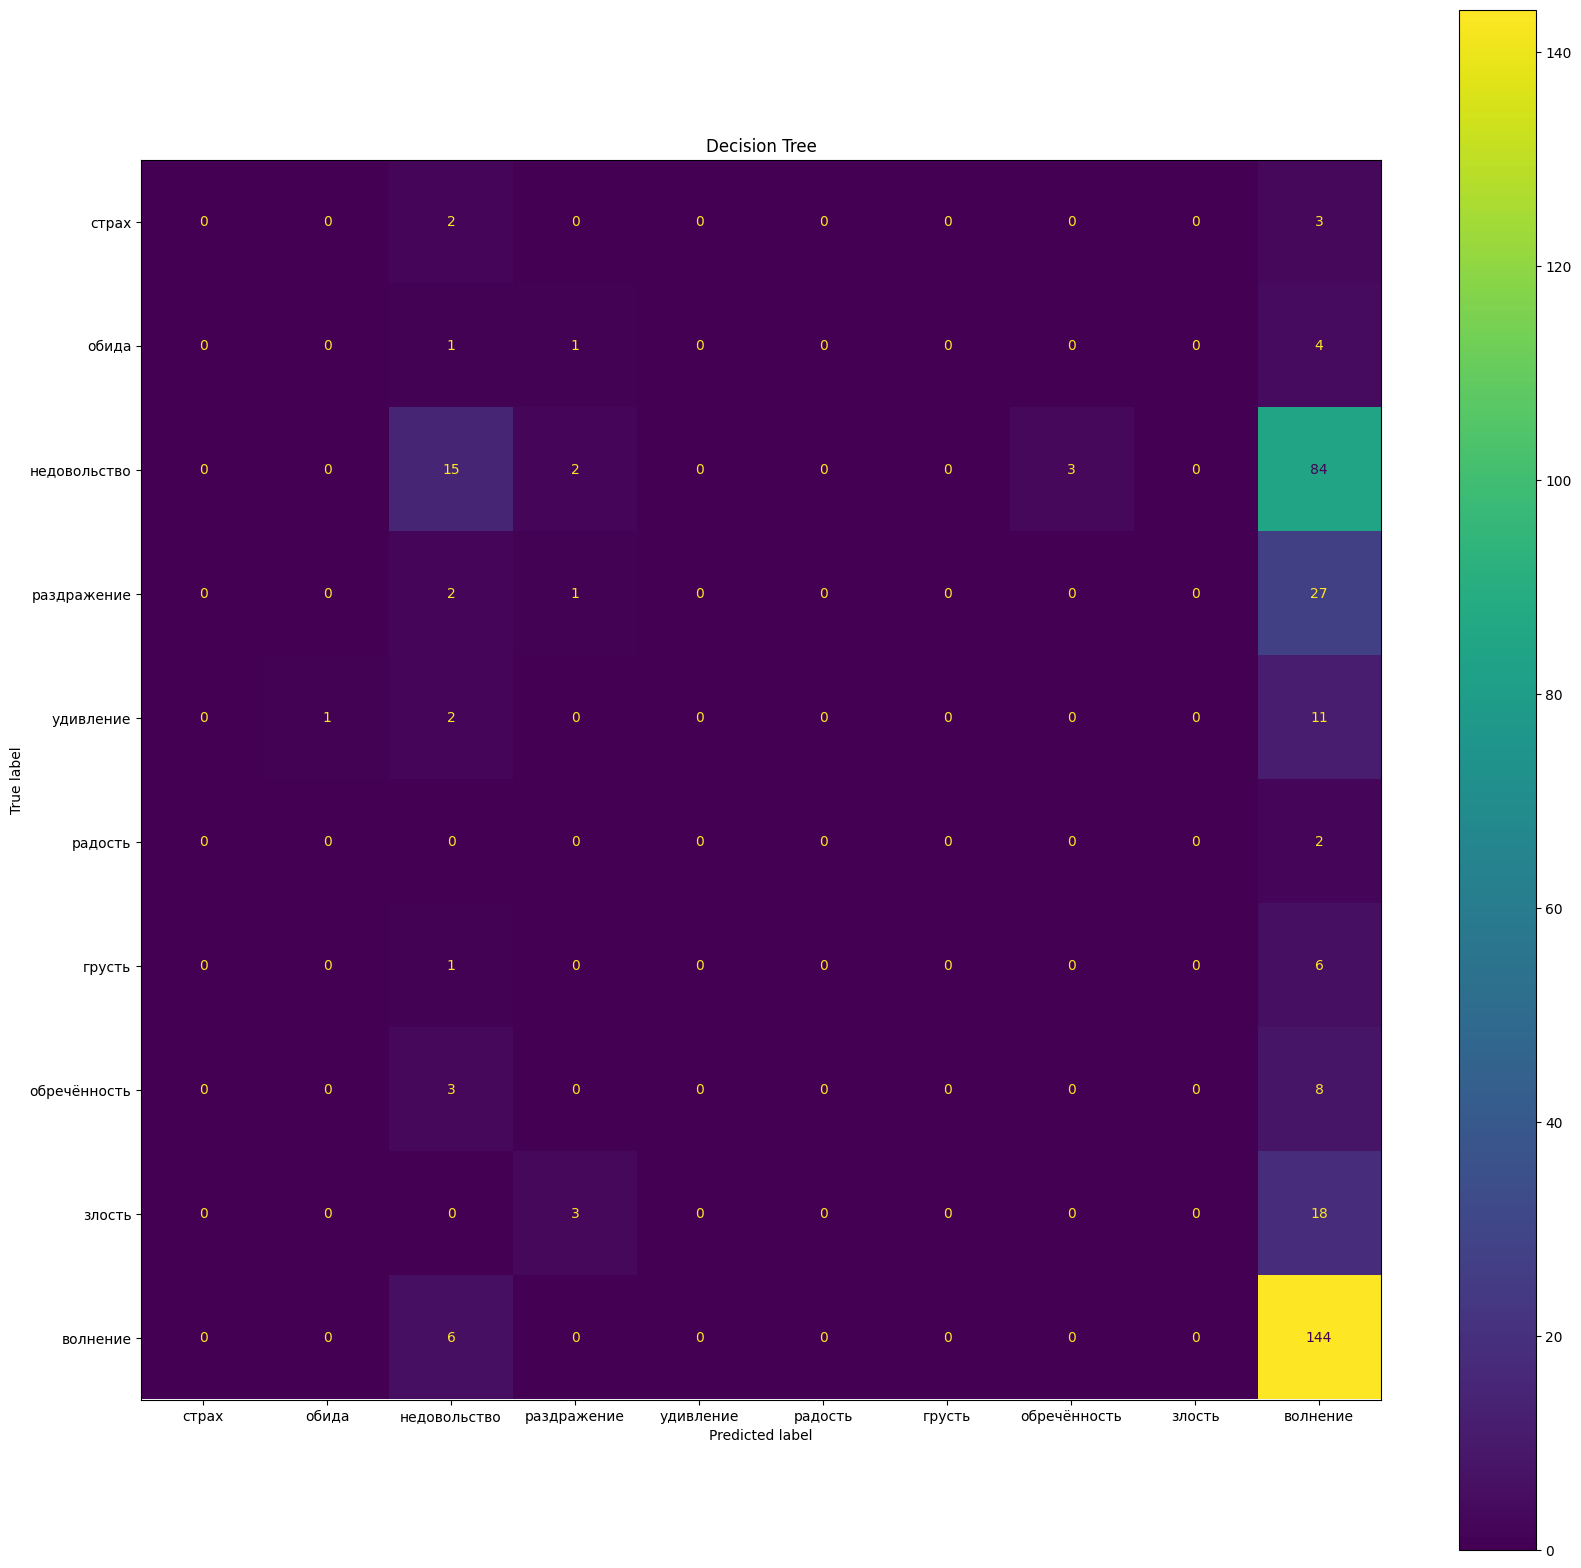

In [32]:
show_conf_matrx(y_test, dec_tree.predict(X_test), dec_tree.classes_, "Decision Tree")

In [33]:
dec_tree.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [ ]:
emo2num = {'С': 1,
           'О': 2,
           'Н': 3,
           'Ж': 4,
           'У': 5,
           'Р': 6,
           'Г': 7,
           'Б': 8,
           'З': 9,
           'В': 10}

num2emo = {val: key for key, val in emo2num.items()}

letter2emo = {
"Г": "грусть",
"З": "злость",
"Р": "радость",
"У": "удивление",
"В": "волнение",
"Ж": "раздражение",
"Н": "недовольство",
"О": "обида",
"Б": "обречённость",
"С": "страх"
}

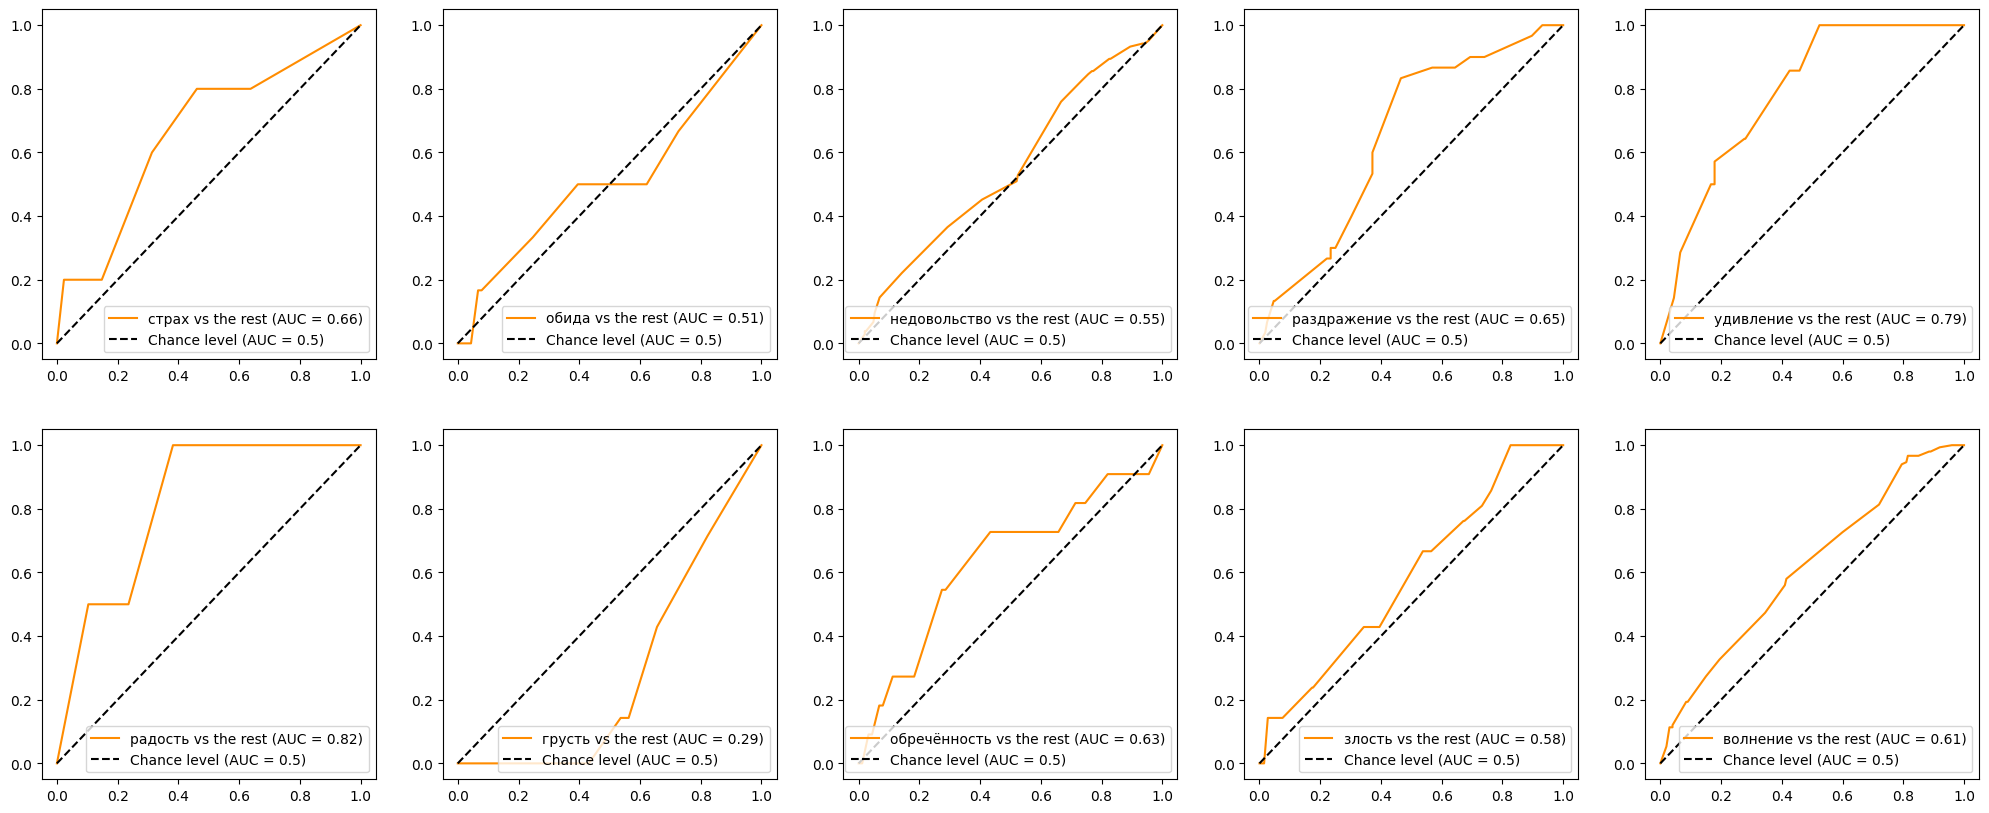

In [101]:
show_roc_curves(y_train, y_test, dec_tree.predict_proba(X_test), classes=dec_tree.classes_)

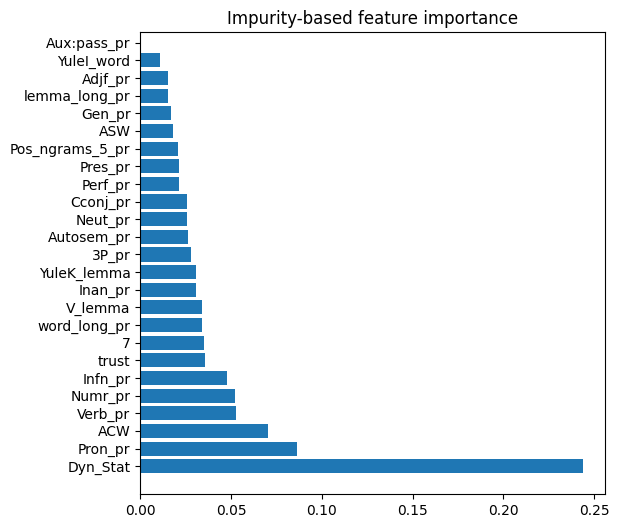

In [102]:
show_feature_importances(dec_tree.feature_importances_, X_test.columns, "Impurity-based feature importance")

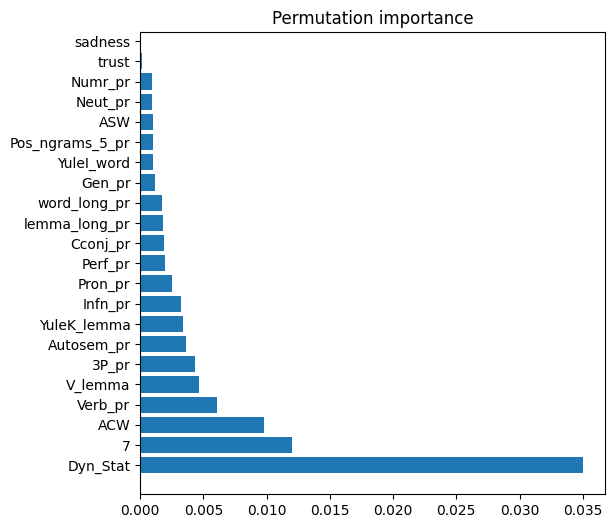

In [105]:
perm_imp_dec_tree = permutation_importance(dec_tree, X_train, y_train, n_repeats=30, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_dec_tree.importances_mean, X_test.columns, "Permutation importance")

## Random Forest

In [78]:
start = time()
rfc = RandomForestClassifier(n_estimators=1000,
                             criterion="gini",
                             max_depth=None, 
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0,
                             max_features="sqrt",
                             max_leaf_nodes=None,
                             min_impurity_decrease=0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=-1,
                             random_state=42,
                             verbose=0,
                             warm_start=False,
                             class_weight=None,
                             ccp_alpha=0,
                             max_samples=None
)
rfc.fit(X=X_train, y=y_train)
print(f"Fit duration: {time() - start:.3}s \n")

print("Test:")
print_metrics(rfc.predict(X_test), y_test, rfc.predict_proba(X_test))
print("\nTrain:")
print_metrics(rfc.predict(X_train), y_train, rfc.predict_proba(X_train))

Fit duration: 5.01s 

Test:
MSE: 19.077142857142857
Accuracy: 0.4714285714285714
F-score: 0.3616493502428332
ROC-AUC: 0.5916899139394091

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 1.0


In [ ]:
# parameters = {
#     "n_estimators": [1000, 1500, 700],
#     "max_depth": [20, 25, 15],
# }

# rfc = RandomForestClassifier(n_jobs=-1,
#                              random_state=42,
#                              max_features="log2",
#                              criterion="gini")

# rfc_grid = GridSearchCV(estimator=rfc, 
#                        param_grid=parameters,
#                        scoring=None,
#                        refit=True,
#                        verbose=4,
#                        pre_dispatch="2*n_jobs",
#                     #    error_score=...,
#                        return_train_score=False,
#                        cv=5,
#                        n_jobs=-1)
# rfc_grid.fit(X_train, y_train)

# rfc_grid.best_params_

In [96]:
rfc = RandomForestClassifier(max_depth=20, 
                             n_estimators=1000,
                             n_jobs=-1,
                             random_state=42,
                             max_features="log2",
                             criterion="gini")

rfc.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(rfc.predict(X_test), y_test, rfc.predict_proba(X_test))
print("\nTrain:")
print_metrics(rfc.predict(X_train), y_train, rfc.predict_proba(X_train))

Test:
MSE: 20.122857142857143
Accuracy: 0.4514285714285714
F-score: 0.3268999945202477
ROC-AUC: 0.6058456163640671

Train:
MSE: 0.17471410419313851
Accuracy: 0.9933290978398983
F-score: 0.9933044476525429
ROC-AUC: 1.0


In [ ]:
# fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
# plt.subplots_adjust(hspace=0.5)
# fig.suptitle("Confusion matrices", fontsize=18, y=0.95)
# mcm_rfc = multilabel_confusion_matrix(y_test, rfc.predict(X_test), labels=rfc.classes_)

# for confusion_matrix, ax, klas in zip(mcm_rfc, axs.ravel(), rfc.classes_):
#     disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=[letter2emo[num2emo[klas]], "other"])
#     disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")

# plt.show()

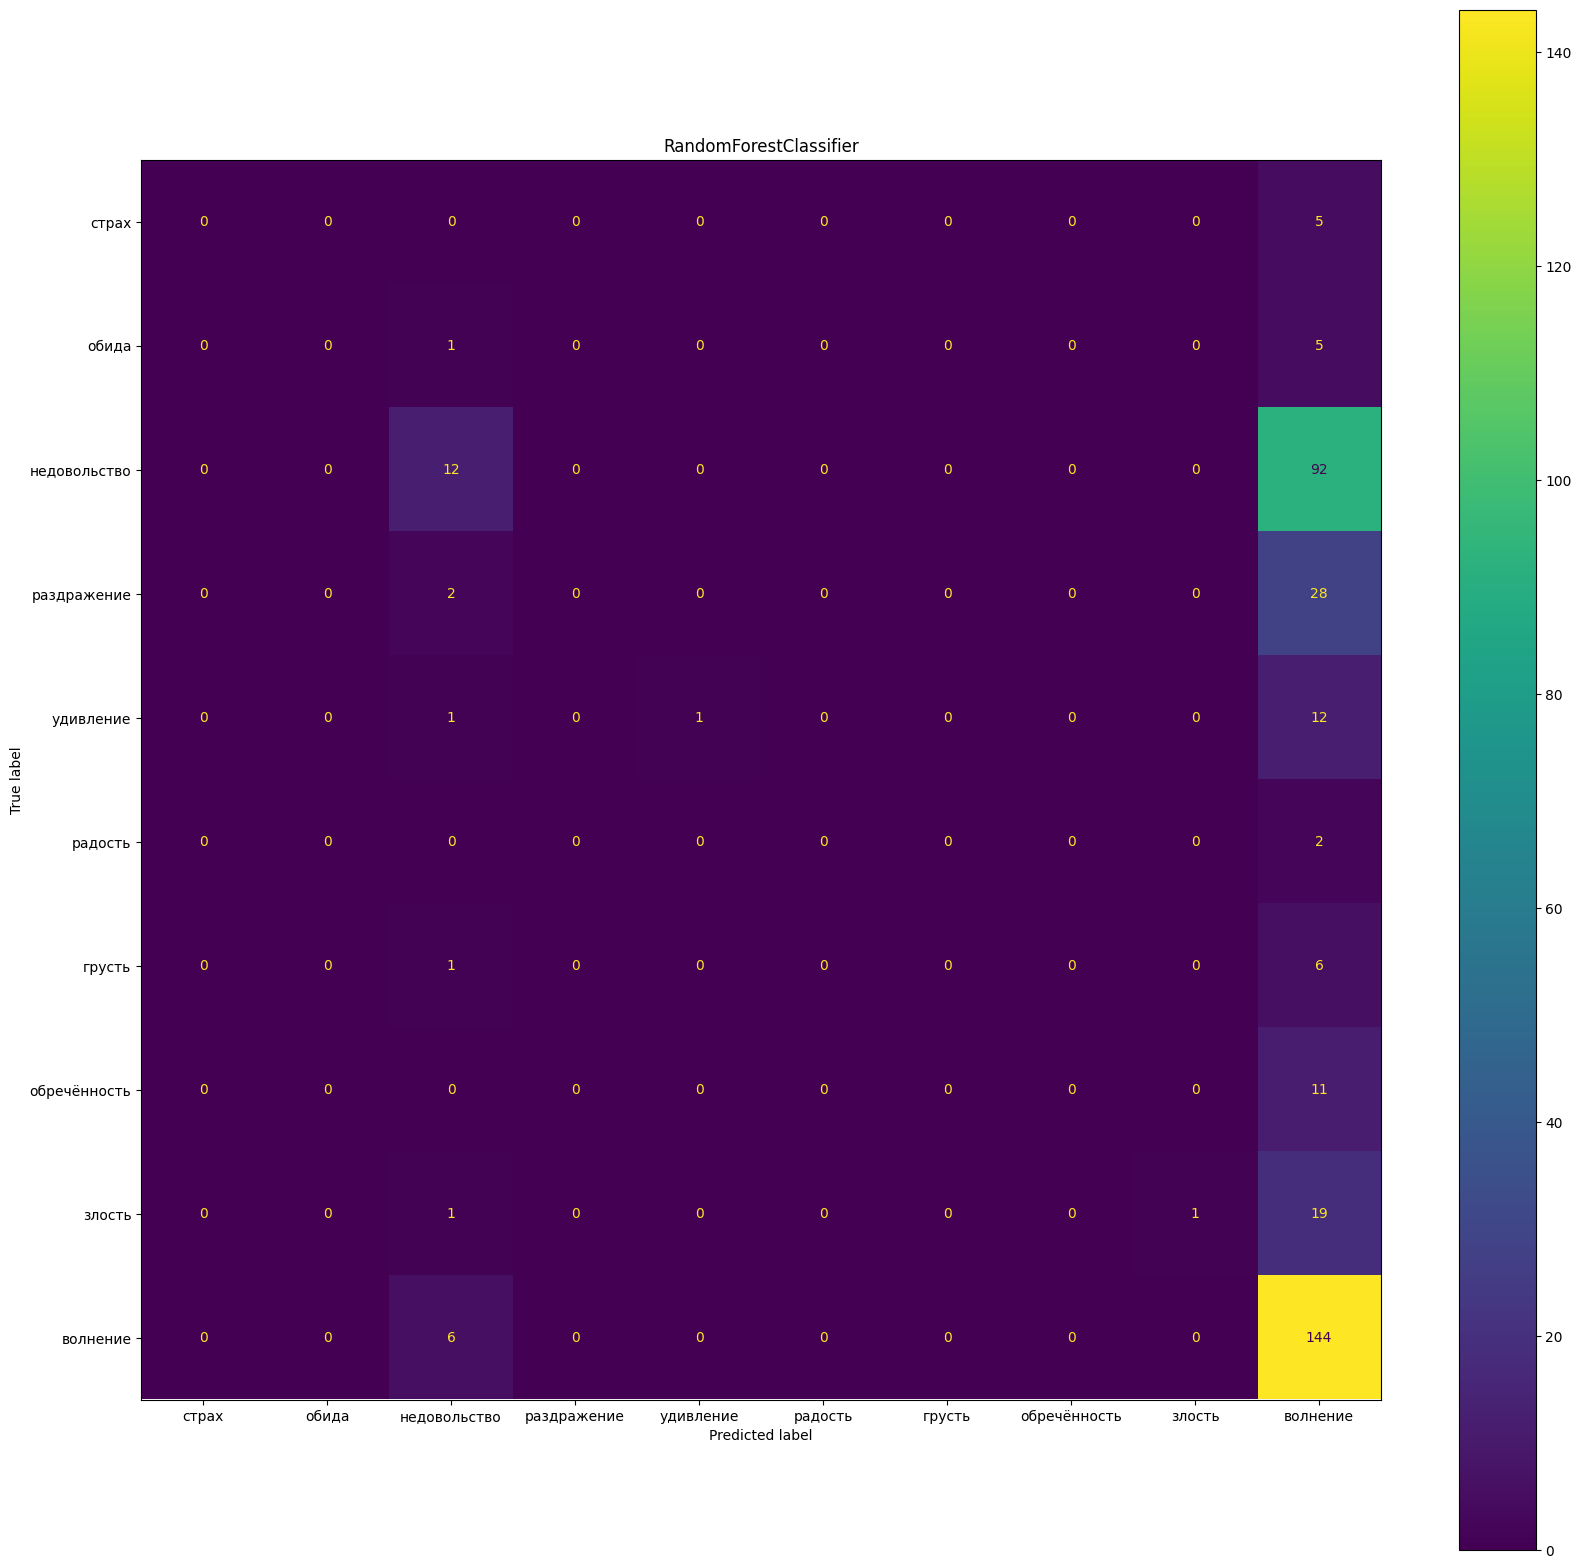

In [97]:
show_conf_matrx(y_test, rfc.predict(X_test), rfc.classes_, "RandomForestClassifier")

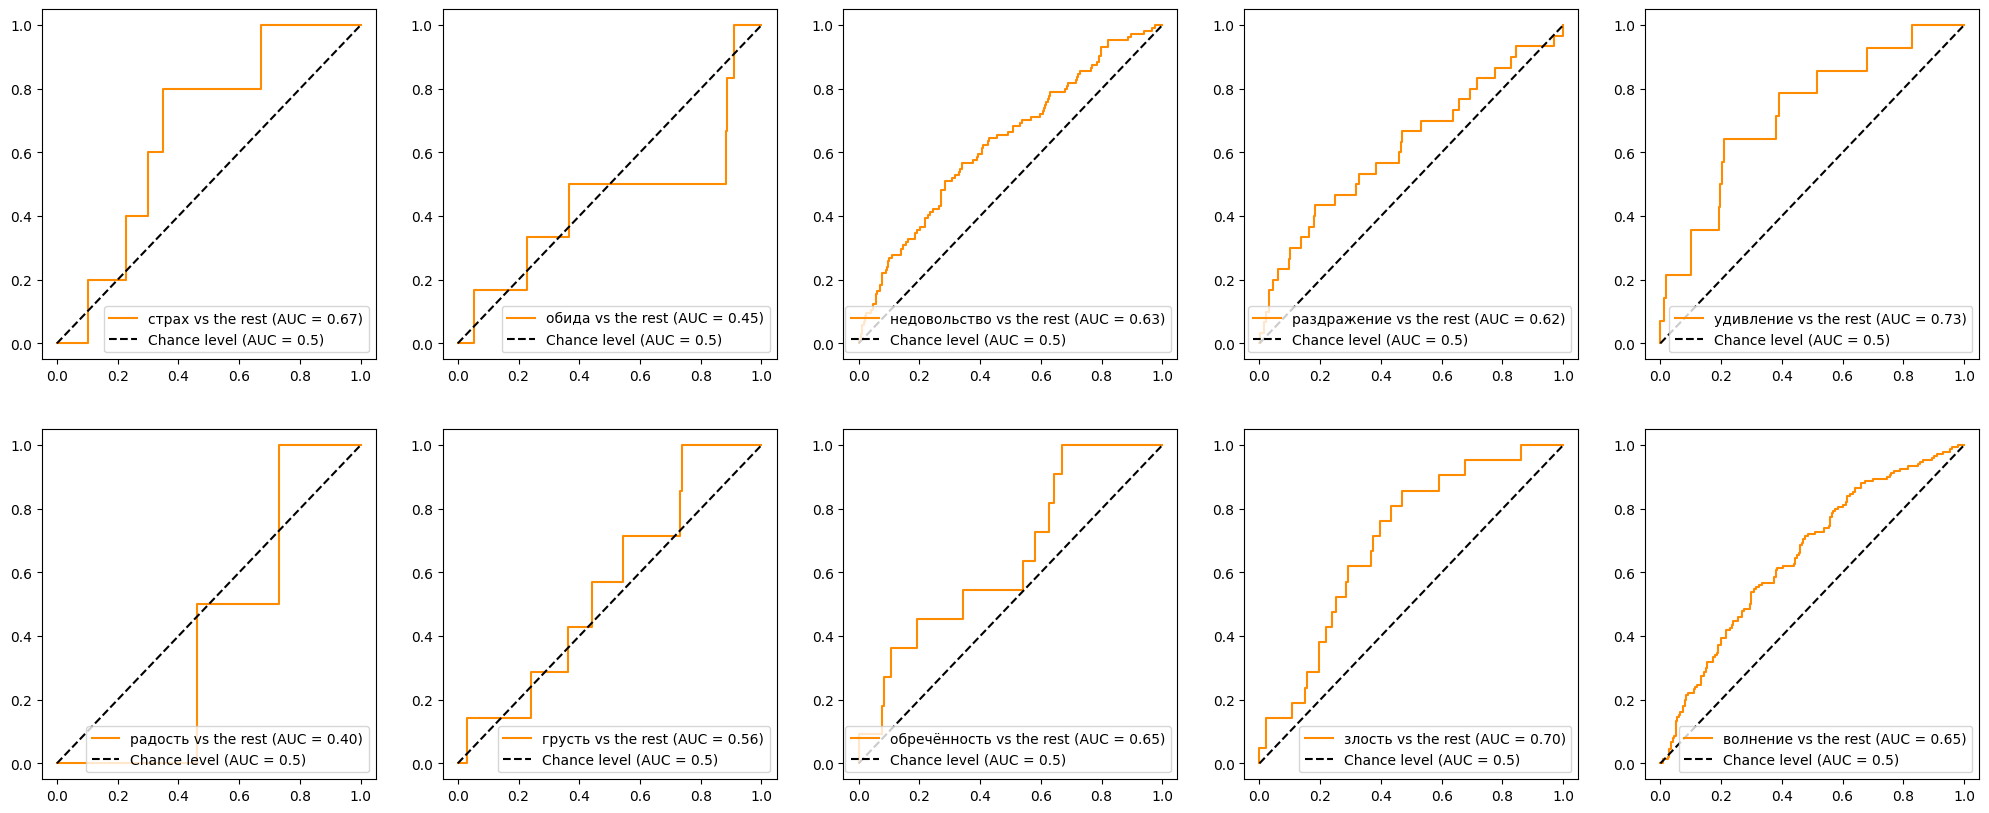

In [98]:
show_roc_curves(y_train, y_test, y_score=rfc.predict_proba(X_test), classes=rfc.classes_)

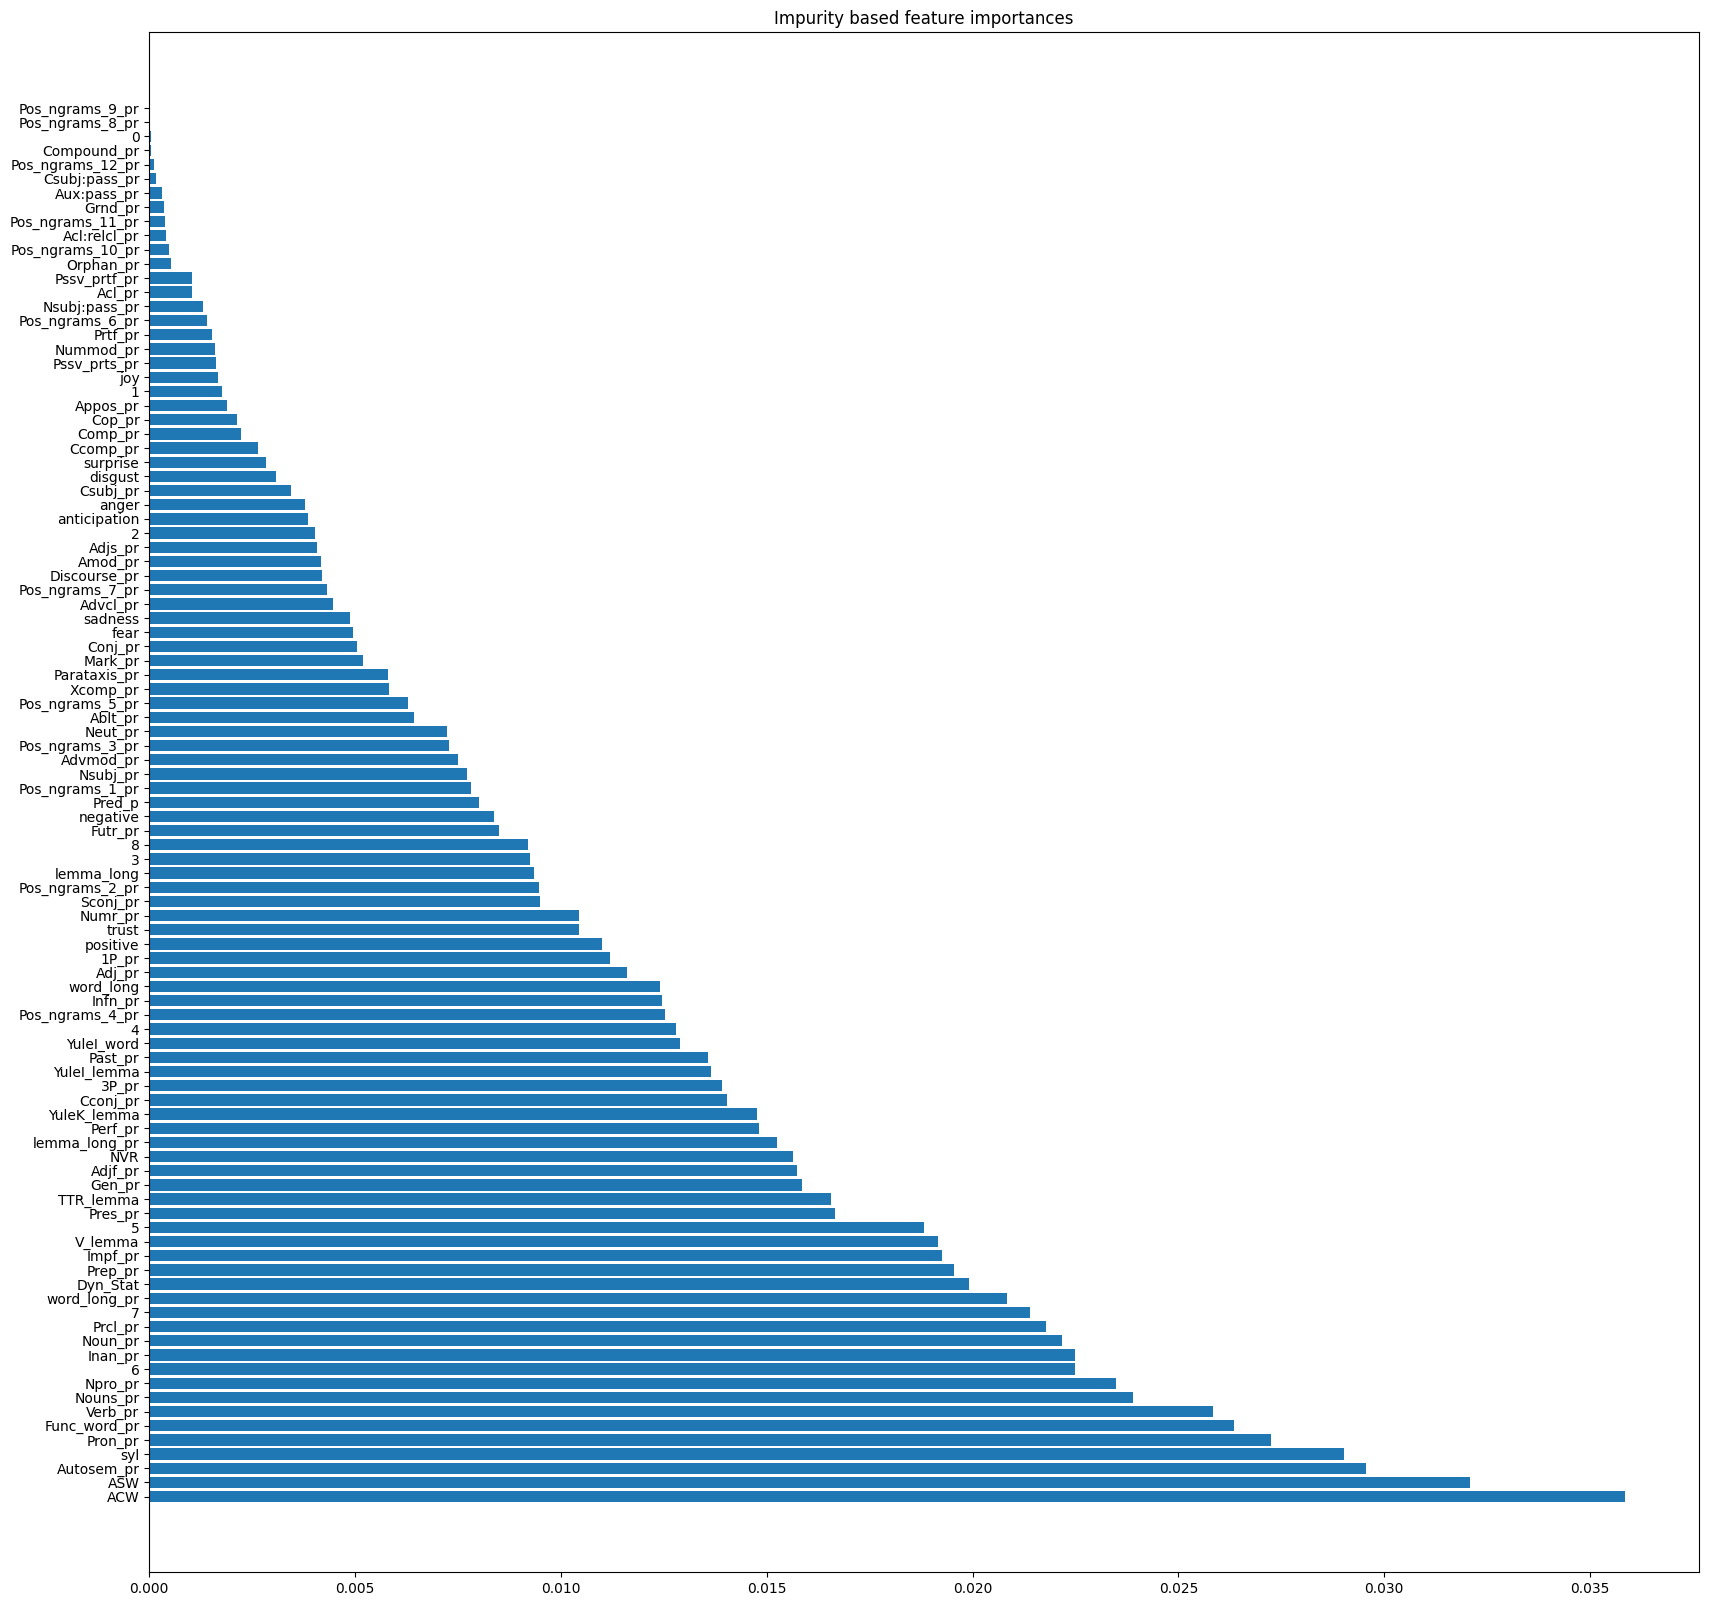

In [104]:
show_feature_importances(rfc.feature_importances_, X_test.columns, "Impurity based feature importances", size=(20,20))

In [ ]:
perm_imp_rfc = permutation_importance(rfc, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)

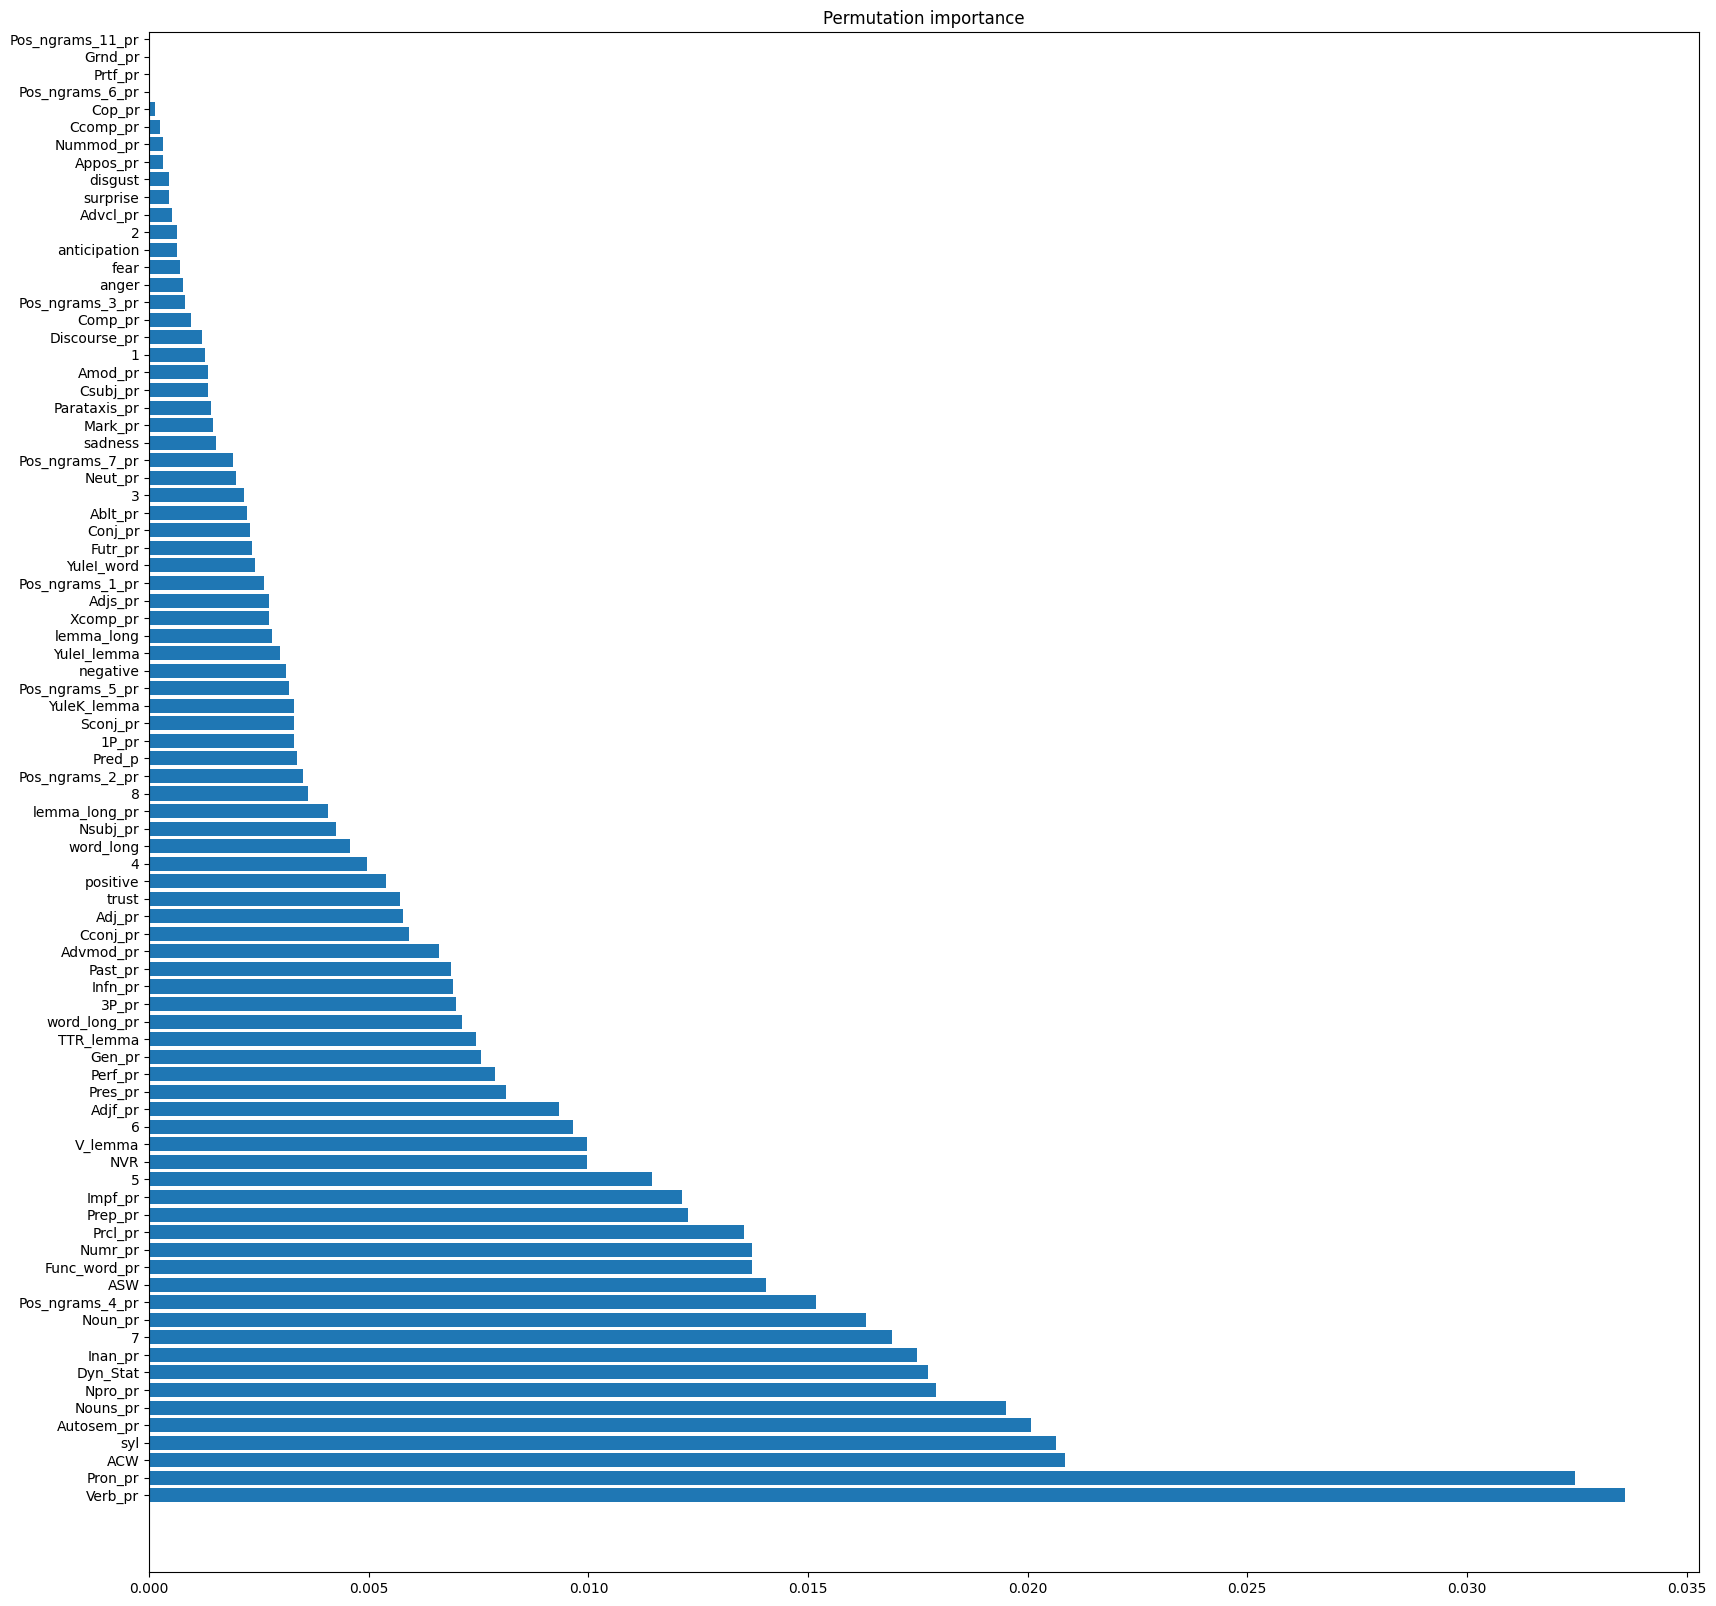

In [108]:
show_feature_importances(perm_imp_rfc.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## CatBoost

In [109]:
cbc = CatBoostClassifier()

cbc.fit(X_train, y_train)
preds_class = cbc.predict(X_test)
print_metrics(preds_class, y_test, cbc.predict_proba(X_test))

Learning rate set to 0.083892
0:	learn: 2.1425607	total: 358ms	remaining: 5m 57s
1:	learn: 2.0270223	total: 561ms	remaining: 4m 40s
2:	learn: 1.9401833	total: 789ms	remaining: 4m 22s
3:	learn: 1.8704842	total: 960ms	remaining: 3m 59s
4:	learn: 1.8142929	total: 1.16s	remaining: 3m 51s
5:	learn: 1.7666433	total: 1.32s	remaining: 3m 39s
6:	learn: 1.7268848	total: 1.46s	remaining: 3m 26s
7:	learn: 1.6929474	total: 1.61s	remaining: 3m 19s
8:	learn: 1.6643863	total: 1.78s	remaining: 3m 16s
9:	learn: 1.6390676	total: 1.97s	remaining: 3m 15s
10:	learn: 1.6150585	total: 2.12s	remaining: 3m 10s
11:	learn: 1.5940420	total: 2.29s	remaining: 3m 8s
12:	learn: 1.5758173	total: 2.48s	remaining: 3m 8s
13:	learn: 1.5596374	total: 2.6s	remaining: 3m 3s
14:	learn: 1.5458901	total: 2.73s	remaining: 2m 59s
15:	learn: 1.5333192	total: 2.86s	remaining: 2m 55s
16:	learn: 1.5217666	total: 3.02s	remaining: 2m 54s
17:	learn: 1.5107776	total: 3.18s	remaining: 2m 53s
18:	learn: 1.4997887	total: 3.34s	remaining: 2m 

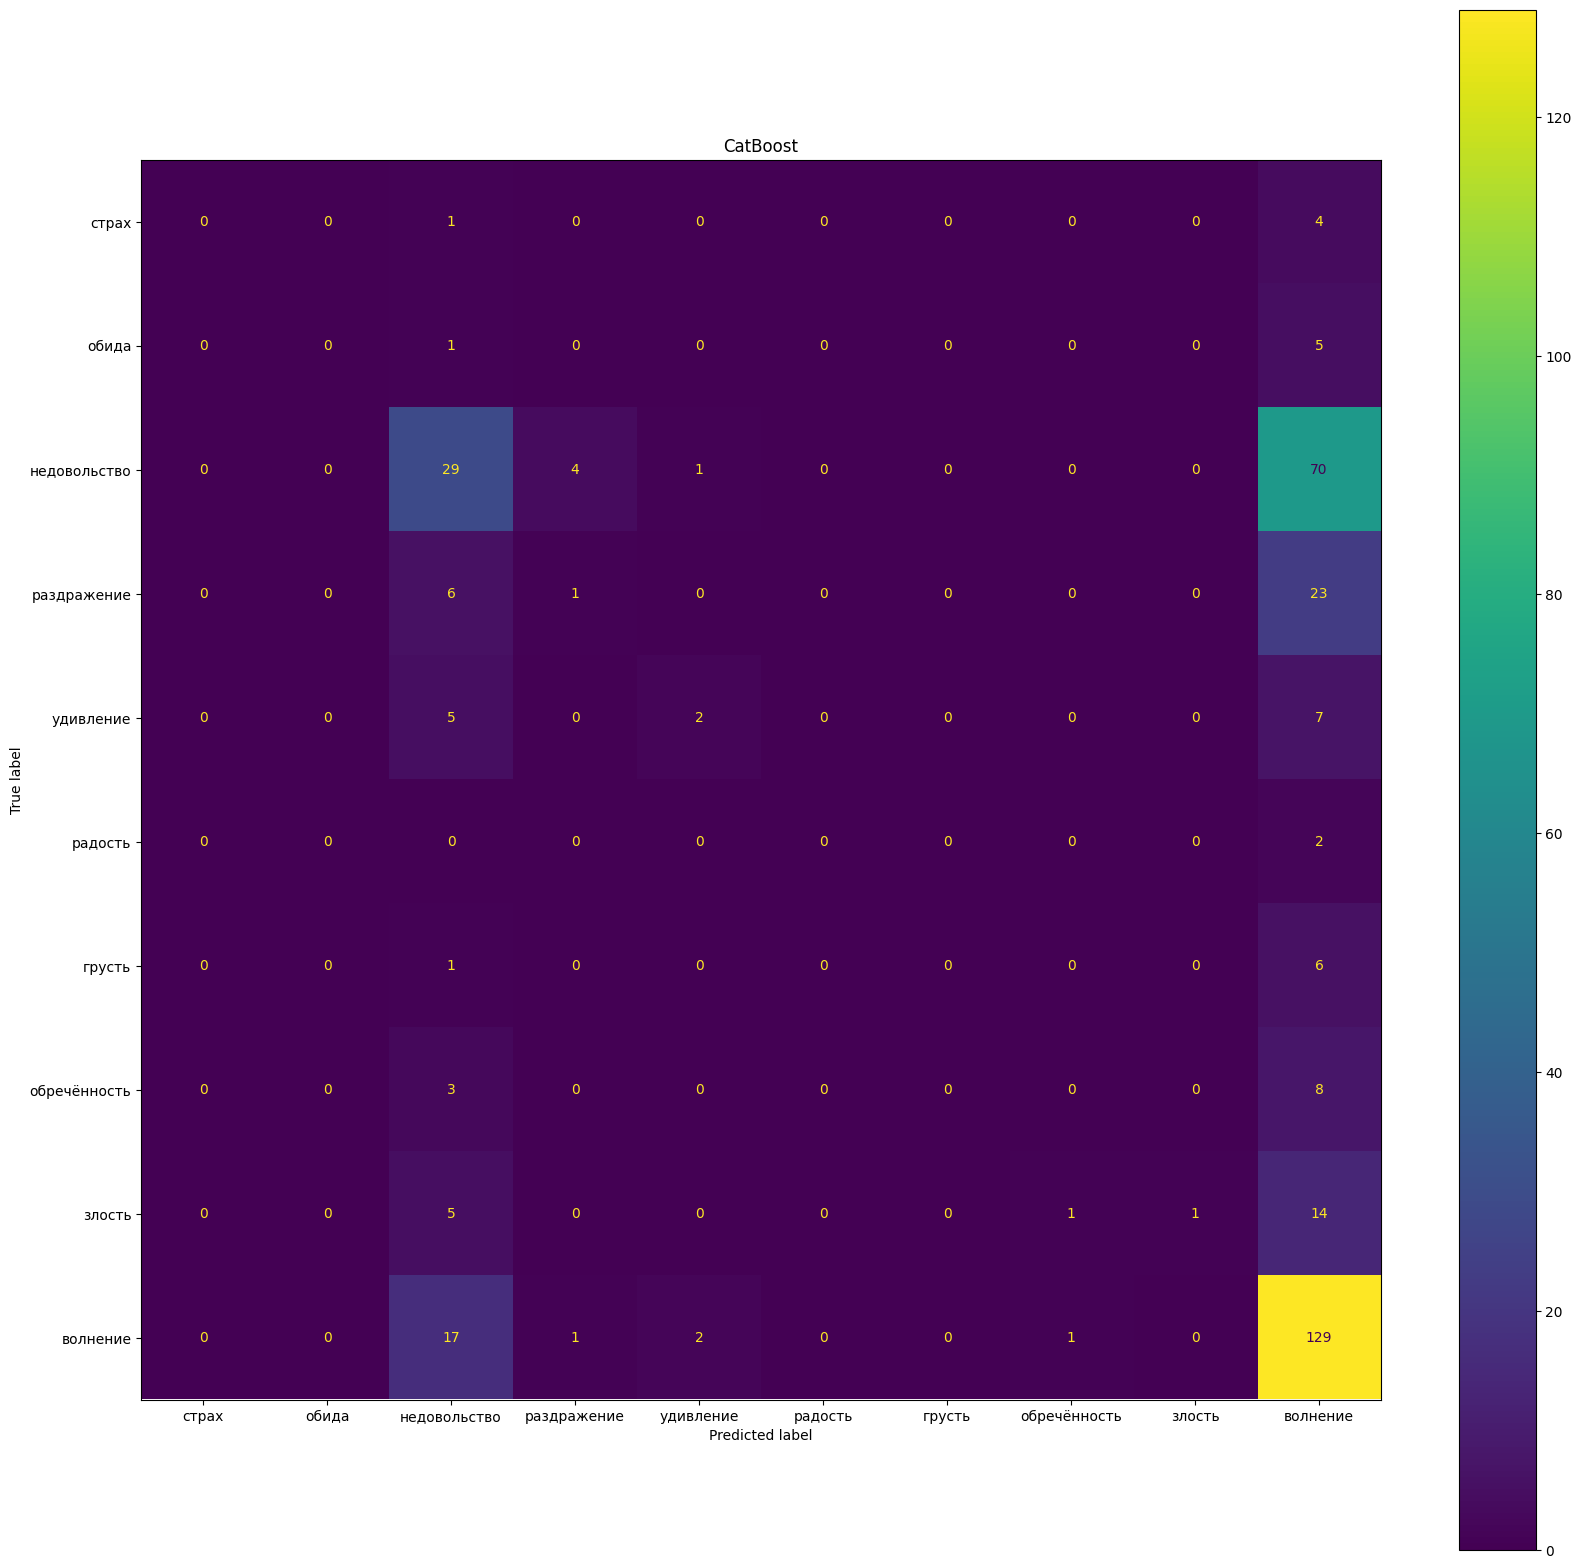

In [110]:
show_conf_matrx(y_test, cbc.predict(X_test), cbc.classes_, "CatBoost")

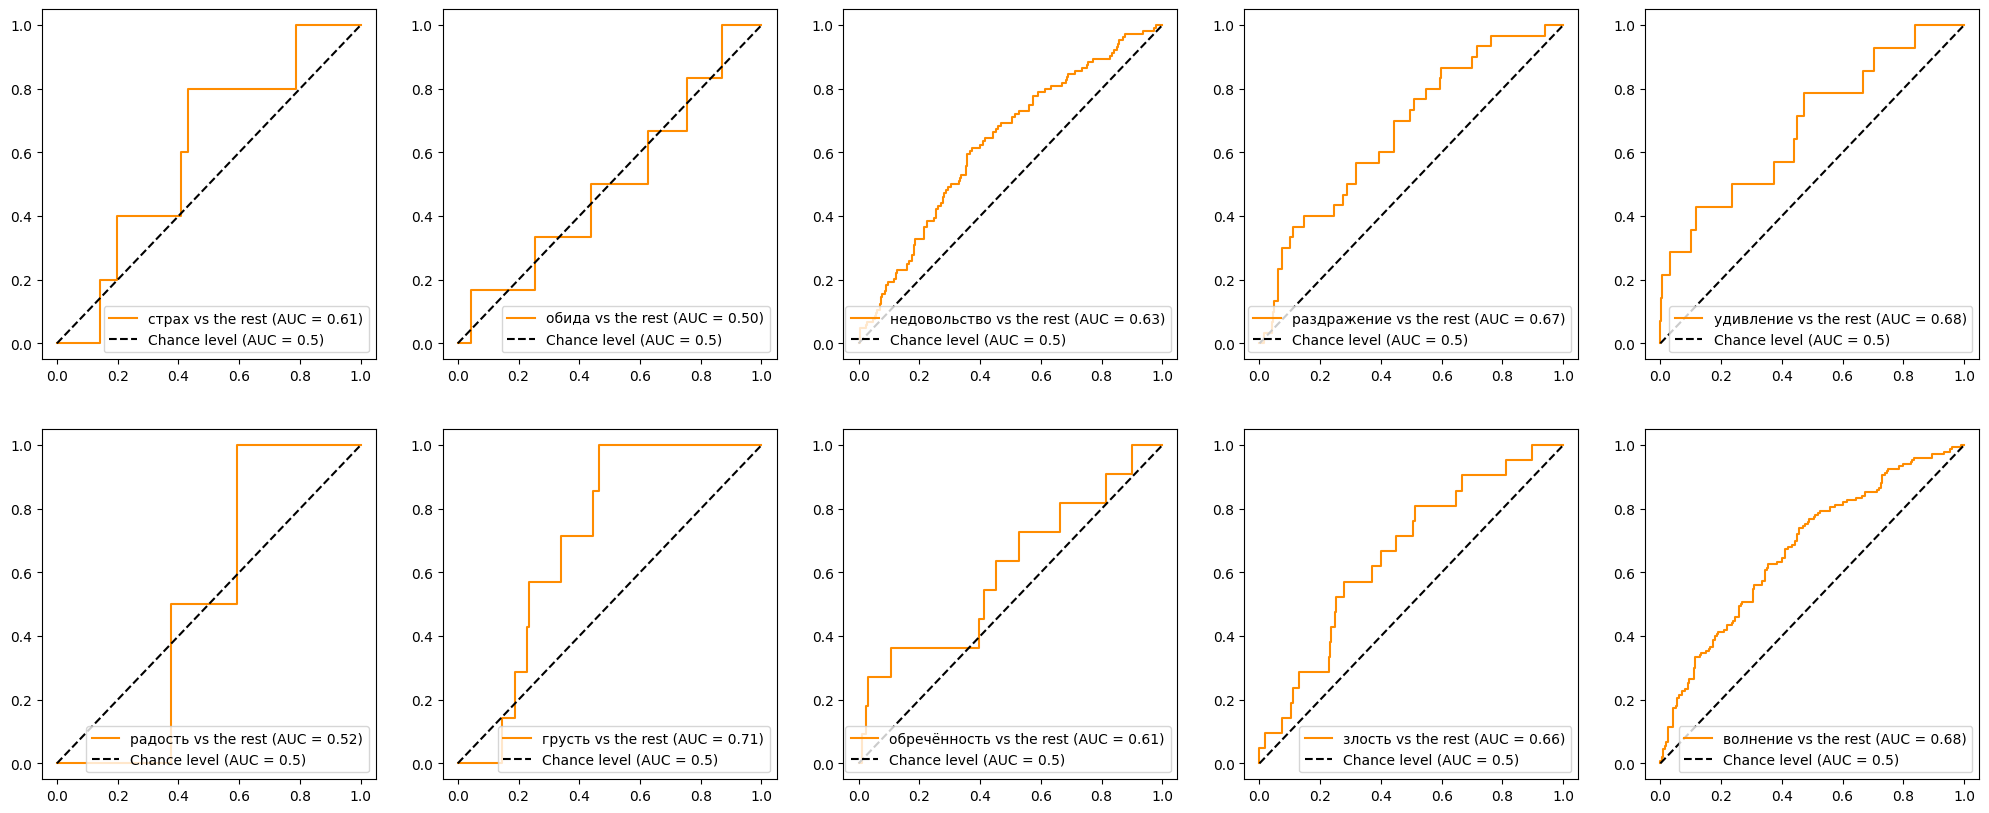

In [111]:
show_roc_curves(y_train, y_test, cbc.predict_proba(X_test), classes=cbc.classes_)

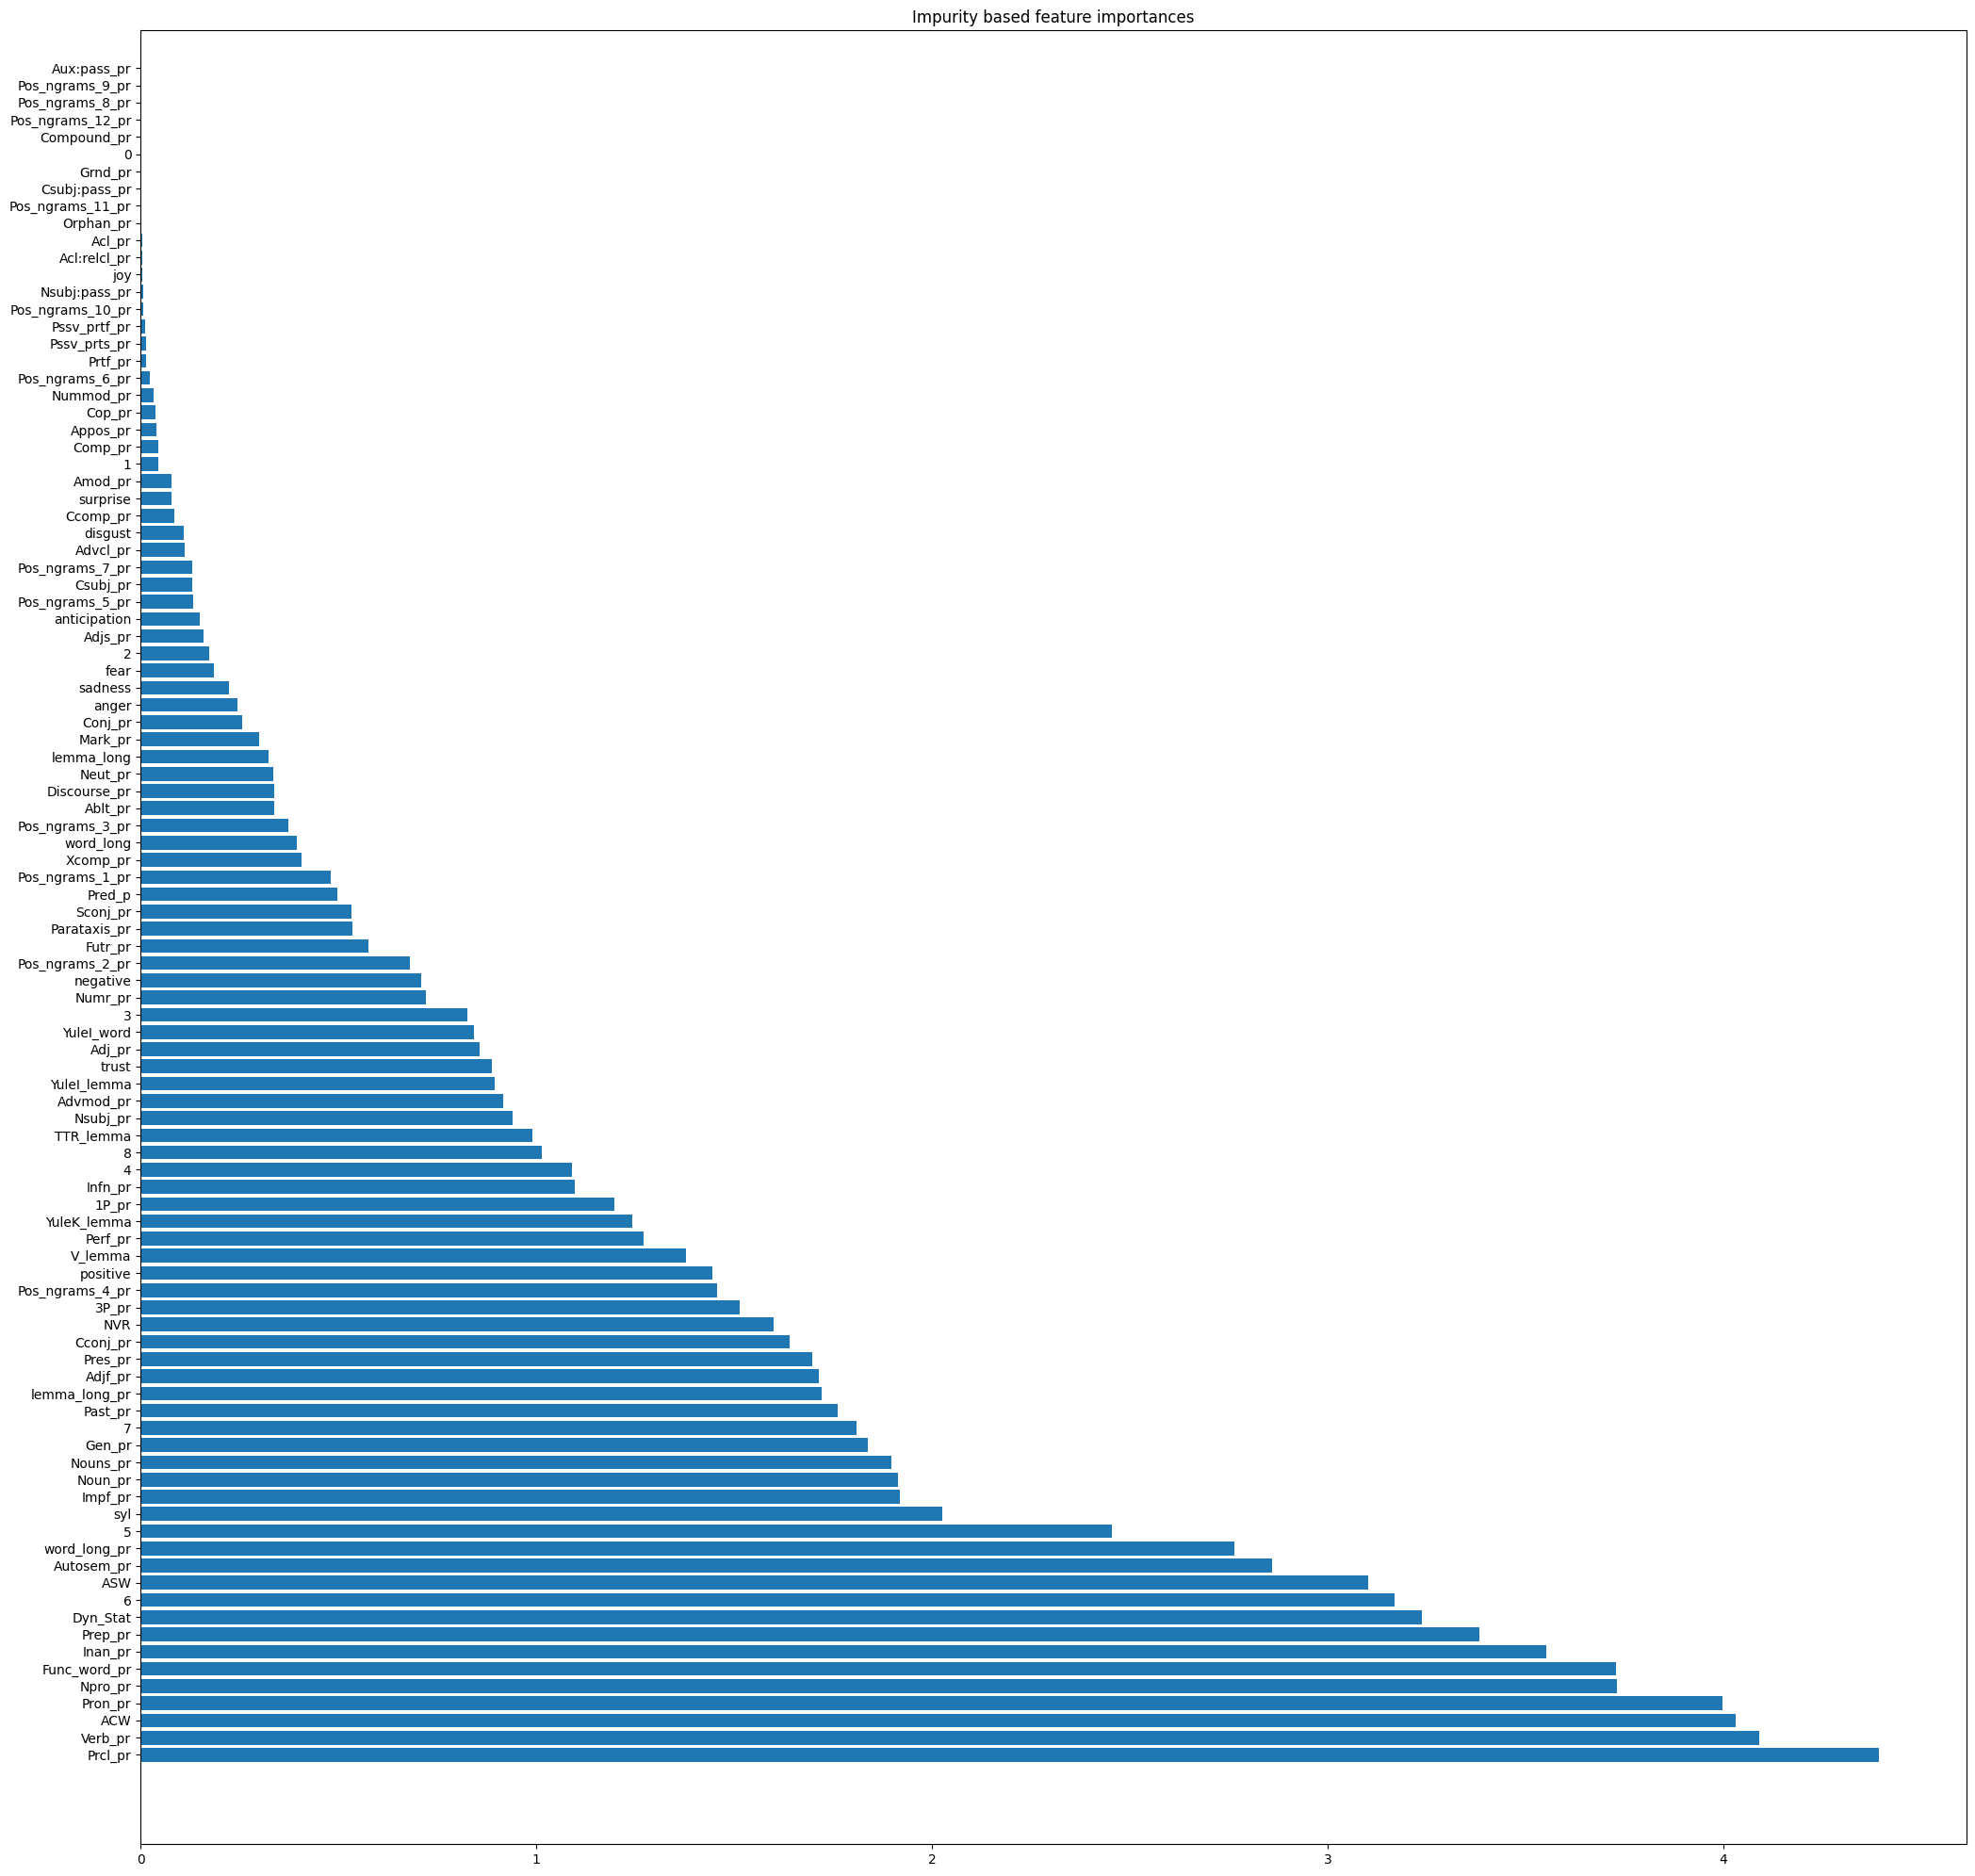

In [115]:
show_feature_importances(cbc.feature_importances_, X_test.columns, "Impurity based feature importances", size=(25,25))

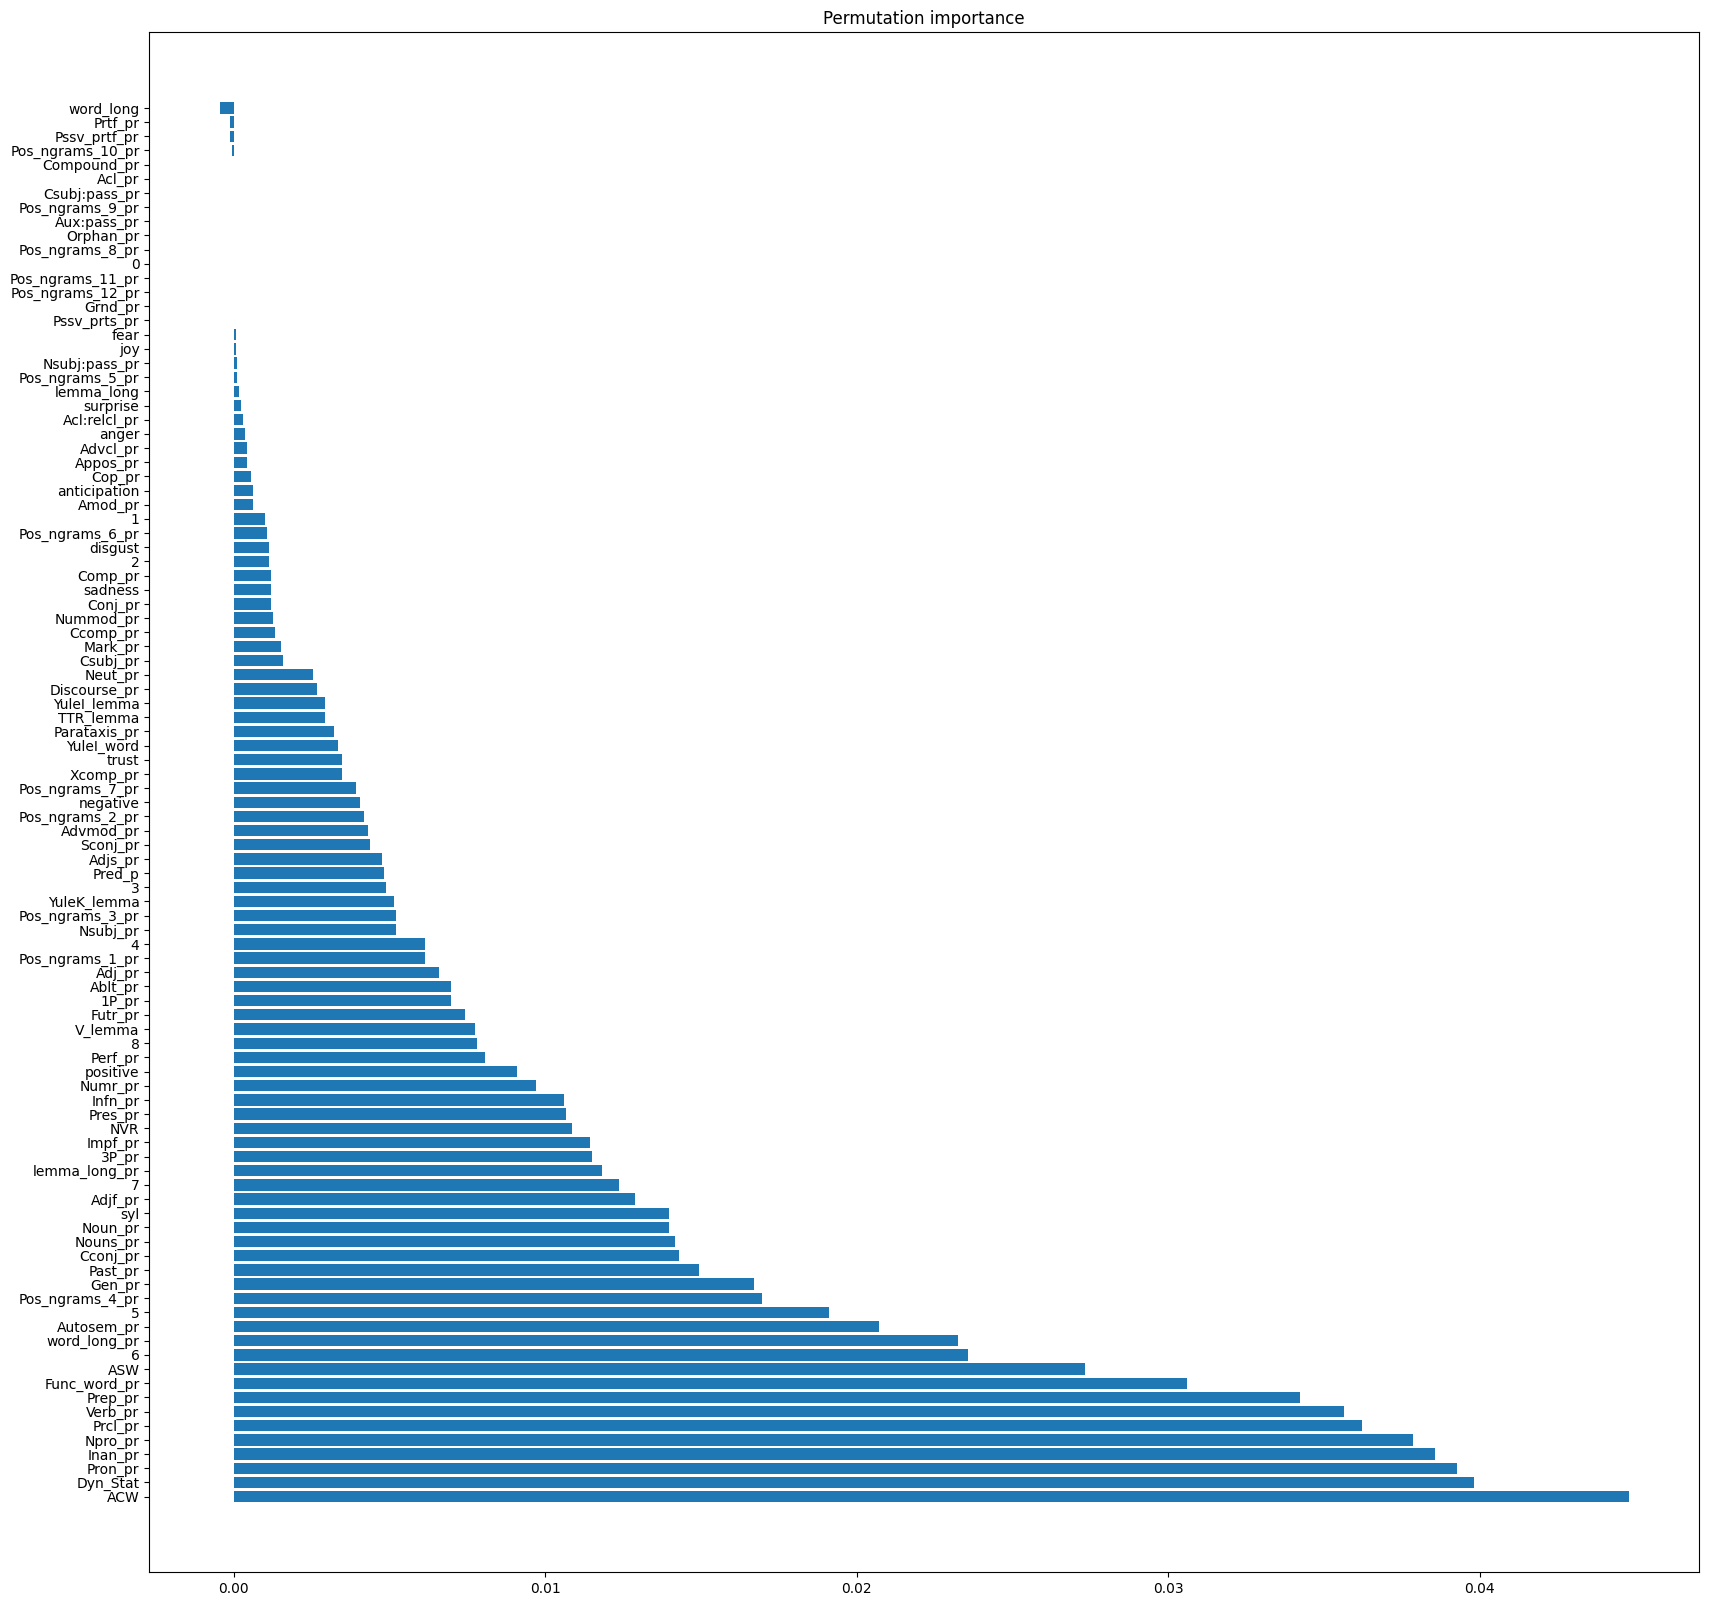

In [113]:
perm_imp_cbc = permutation_importance(cbc, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_cbc.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## Gaussian Naive Bayes

In [116]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)#.predict(X_test)

print_metrics(gnb.predict(X_test), y_test, gnb.predict_proba(X_test))

MSE: 32.254285714285714
Accuracy: 0.04
F-score: 0.019107395231310432
ROC-AUC: 0.6127727213276248


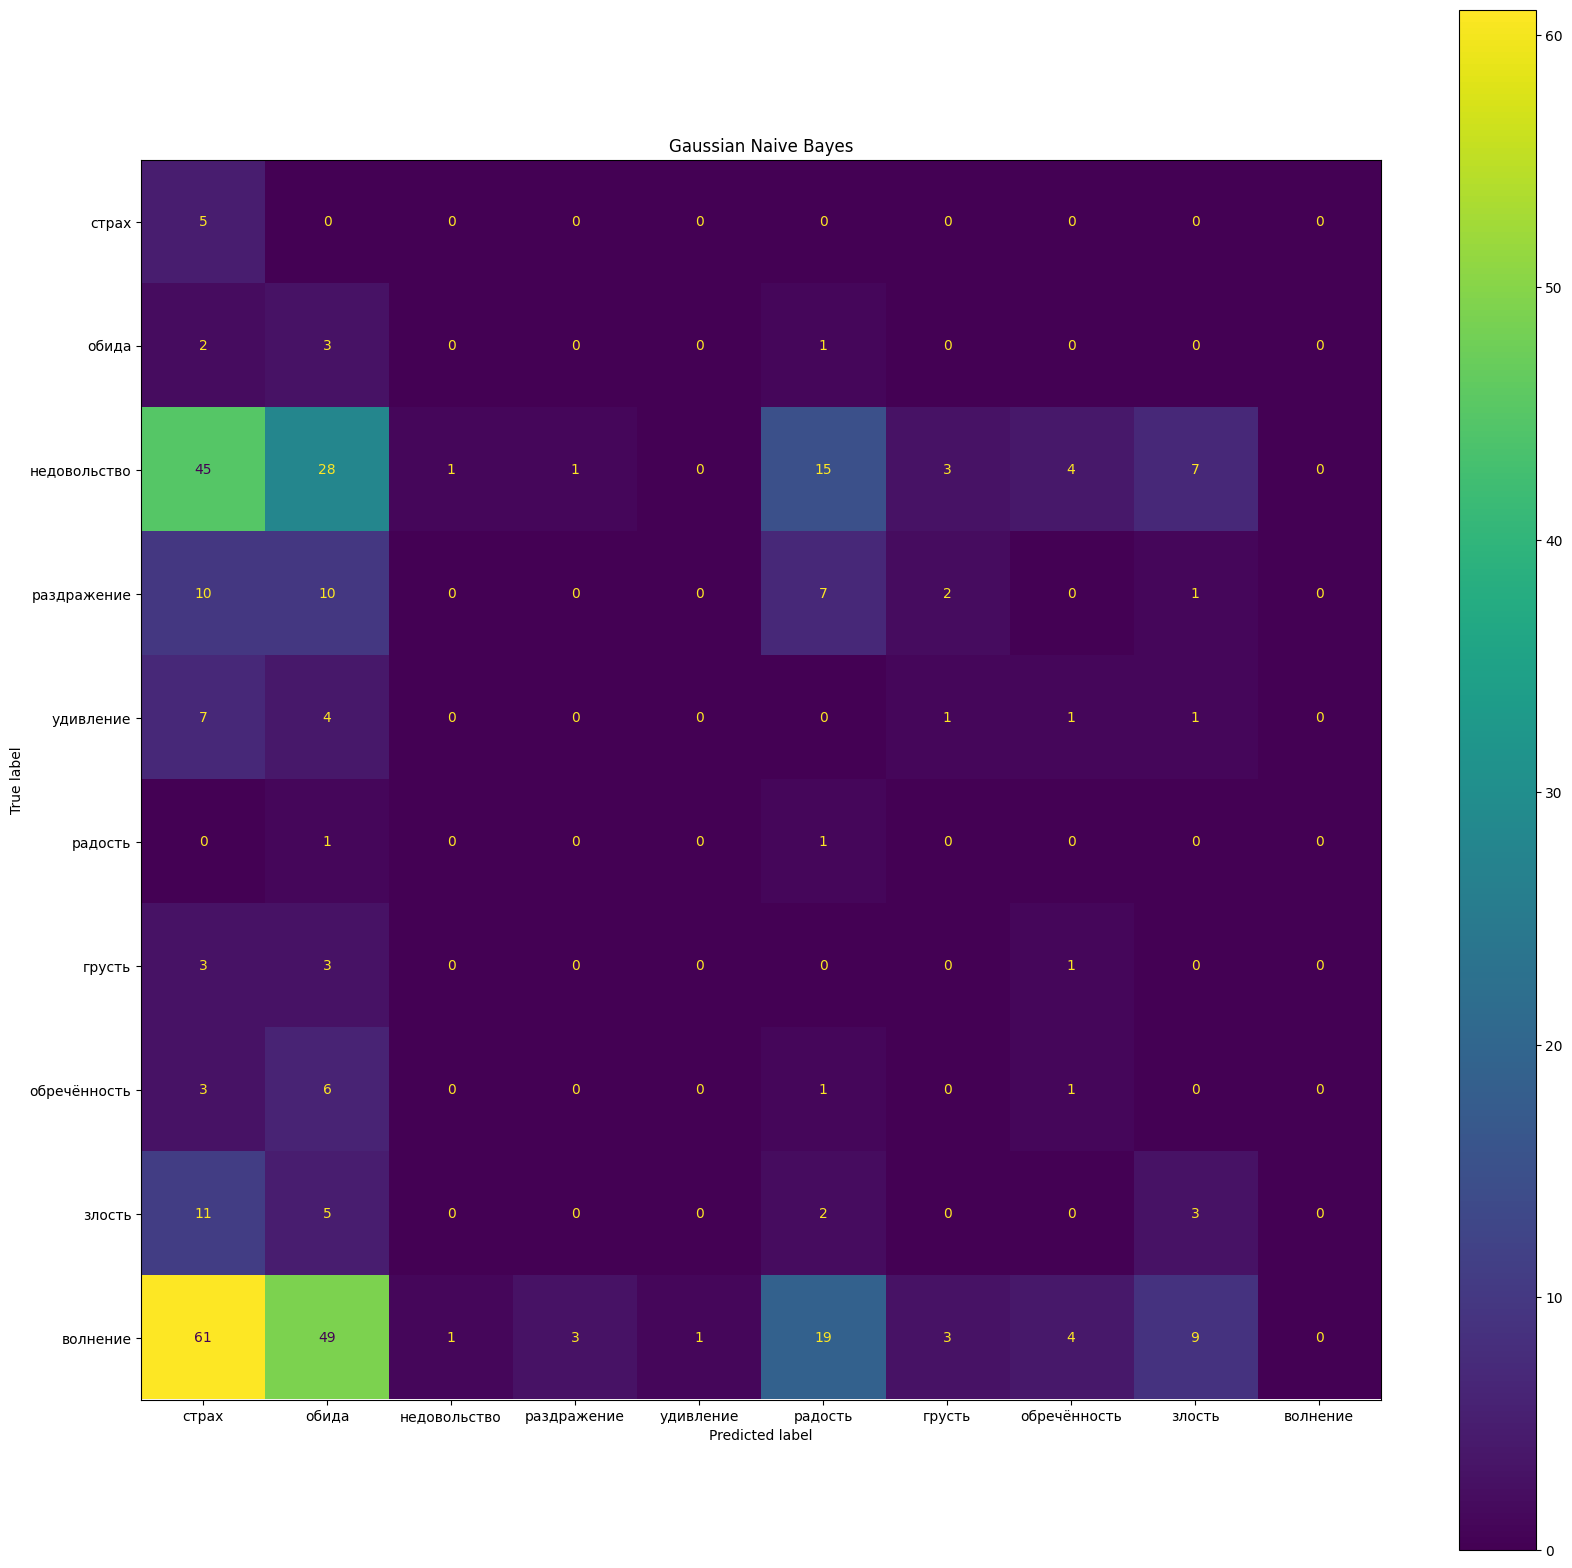

In [117]:
show_conf_matrx(y_test, gnb.predict(X_test), gnb.classes_, "Gaussian Naive Bayes")

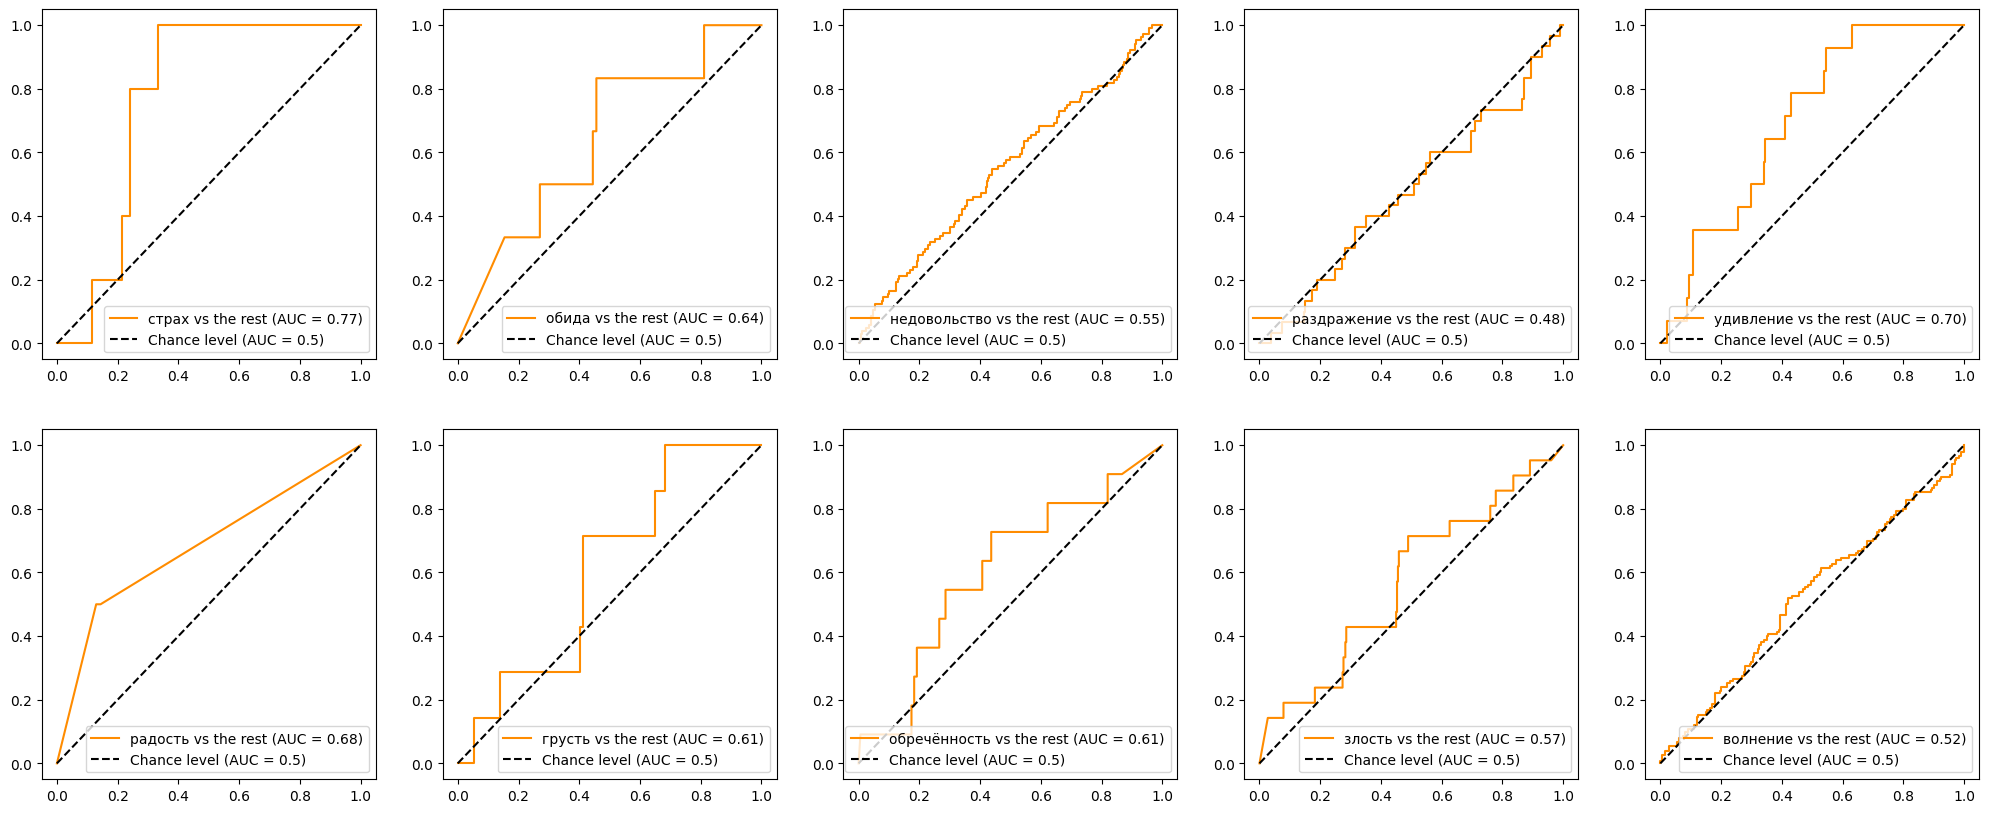

In [118]:
show_roc_curves(y_train, y_test, gnb.predict_proba(X_test), classes=gnb.classes_)

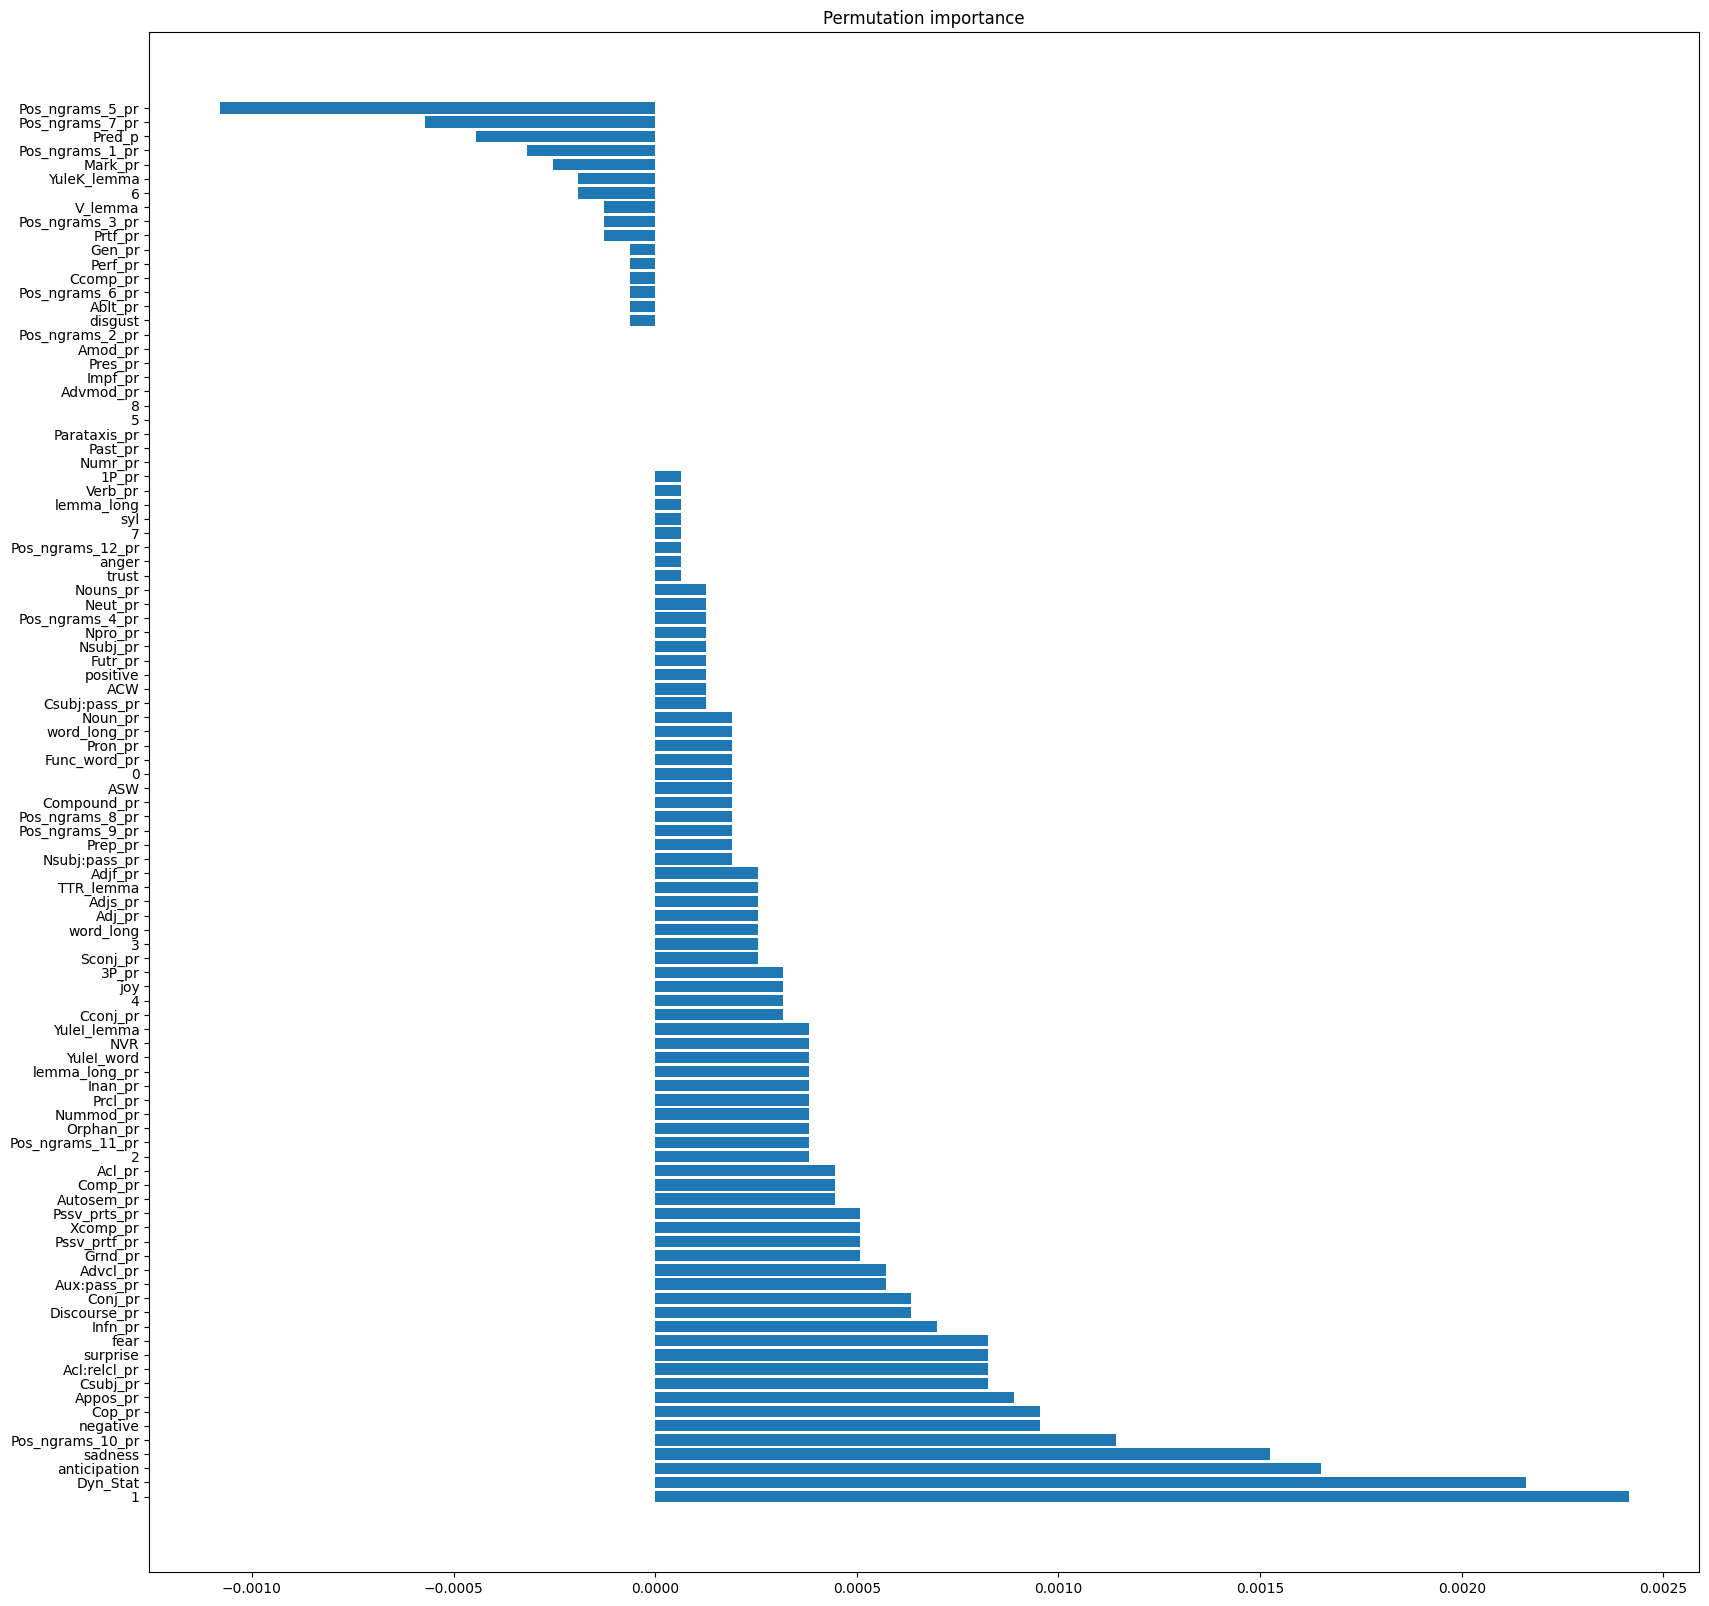

In [119]:
perm_imp_gnb = permutation_importance(gnb, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_gnb.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## K Nearest Neighbors

In [ ]:
knc = KNeighborsClassifier()

knc.fit(X=X_train, y=y_train)

print_metrics(knc.predict(X_test), y_test, knc.predict_proba(X_test))

MSE: 18.825714285714287
Accuracy: 0.39714285714285713
F-score: 0.35004853880444425
ROC-AUC: 0.5575450938372631


## Ridge (Linear classifiers) 

In [ ]:
ridge = RidgeClassifier()

ridge.fit(X=X_train, y=y_train)

print_metrics(ridge.predict(X=X_test), y=y_test)

MSE: 19.837142857142858
Accuracy: 0.44
F-score: 0.35127464618377363


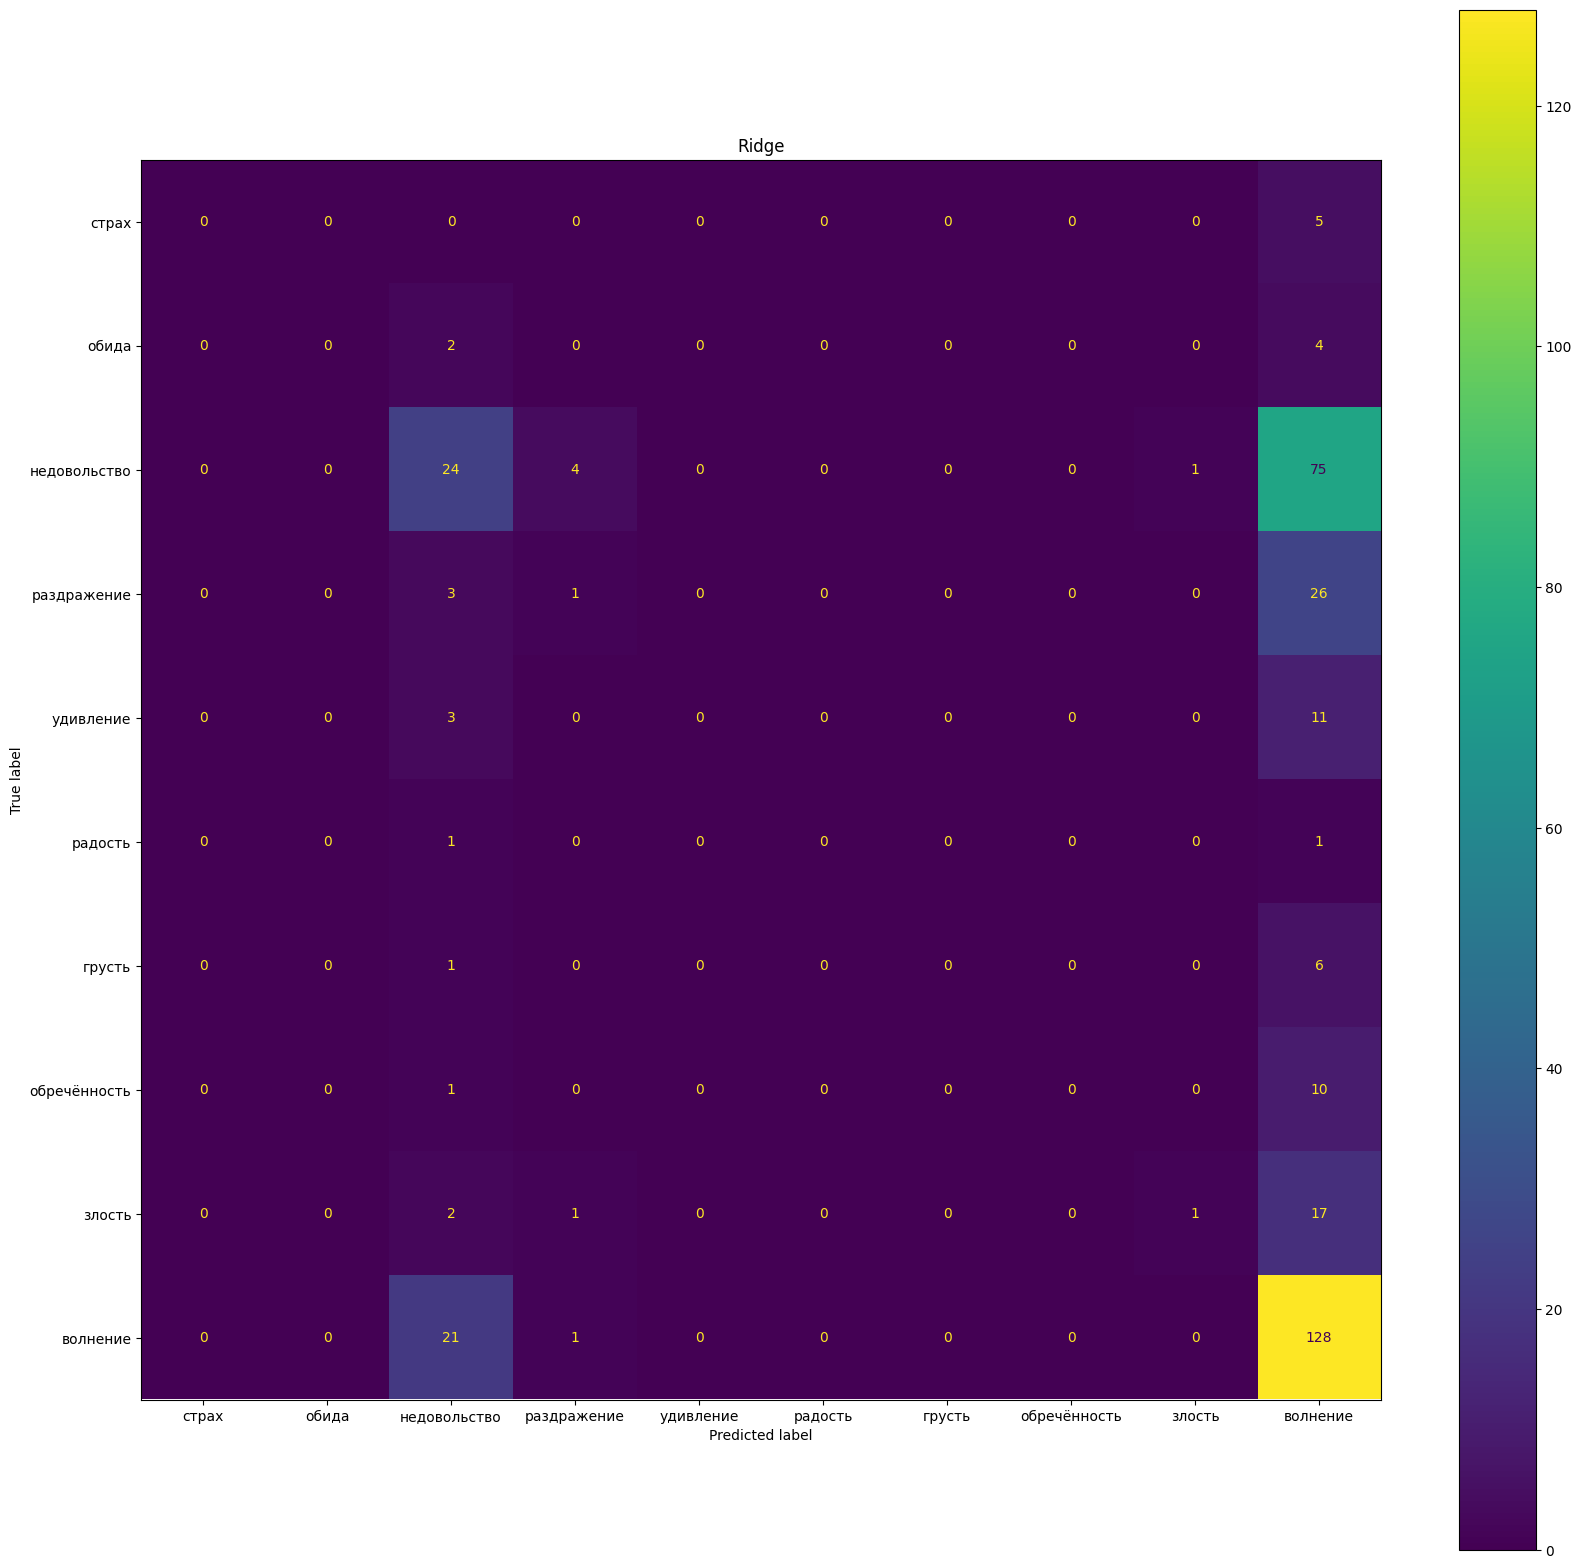

In [ ]:
show_conf_matrx(y_test, ridge.predict(X_test), ridge.classes_, "Ridge")

## Gaussian Process

In [ ]:
gpc = GaussianProcessClassifier(kernel=(1.0 * RBF(1.0)),
                                optimizer="fmin_l_bfgs_b",
                                n_restarts_optimizer=0,
                                max_iter_predict=100,
                                warm_start=False,
                                copy_X_train=True,
                                random_state=42,
                                multi_class="one_vs_rest", # "one_vs_one",
                                n_jobs=-1)
gpc.fit(X=X_train, y=y_train)

print_metrics(gpc.predict(X_test), y_test, gpc.predict_proba(X_test))

MSE: 21.357142857142858
Accuracy: 0.42857142857142855
F-score: 0.2571428571428571
ROC-AUC: 0.5497085685152714


## Support Vecs

In [120]:
linSVM = SVC(kernel="linear", C=0.025, random_state=42, probability=True)
rbfSVM = SVC(gamma=2, C=1, random_state=42, probability=True)

In [121]:
rbfSVM.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(rbfSVM.predict(X_test), y_test, rbfSVM.predict_proba(X_test))
print("\nTrain:")
print_metrics(rbfSVM.predict(X_train), y_train, rbfSVM.predict_proba(X_train))

Test:
MSE: 21.145714285714284
Accuracy: 0.4342857142857143
F-score: 0.26916875665929024
ROC-AUC: 0.48845359653388964

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 0.02258603407951888


In [122]:
linSVM.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(linSVM.predict(X_test), y_test, linSVM.predict_proba(X_test))
print("\nTrain:")
print_metrics(linSVM.predict(X_train), y_train, linSVM.predict_proba(X_train))

Test:
MSE: 21.60857142857143
Accuracy: 0.4228571428571429
F-score: 0.26004810004810003
ROC-AUC: 0.601418579323431

Train:
MSE: 17.724587039390087
Accuracy: 0.5022236340533672
F-score: 0.3413394457578908
ROC-AUC: 0.7421550938111007


In [148]:
svm = SVC(random_state = 42, 
          C=2,
          probability=True)
svm.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(svm.predict(X_test), y_test, svm.predict_proba(X_test))
print("\nTrain:")
print_metrics(svm.predict(X_train), y_train, svm.predict_proba(X_train))

Test:
MSE: 19.48
Accuracy: 0.45714285714285713
F-score: 0.358971584720583
ROC-AUC: 0.6019517762652764

Train:
MSE: 8.470457433290978
Accuracy: 0.7229987293519695
F-score: 0.6858350202692011
ROC-AUC: 0.8947100462134772


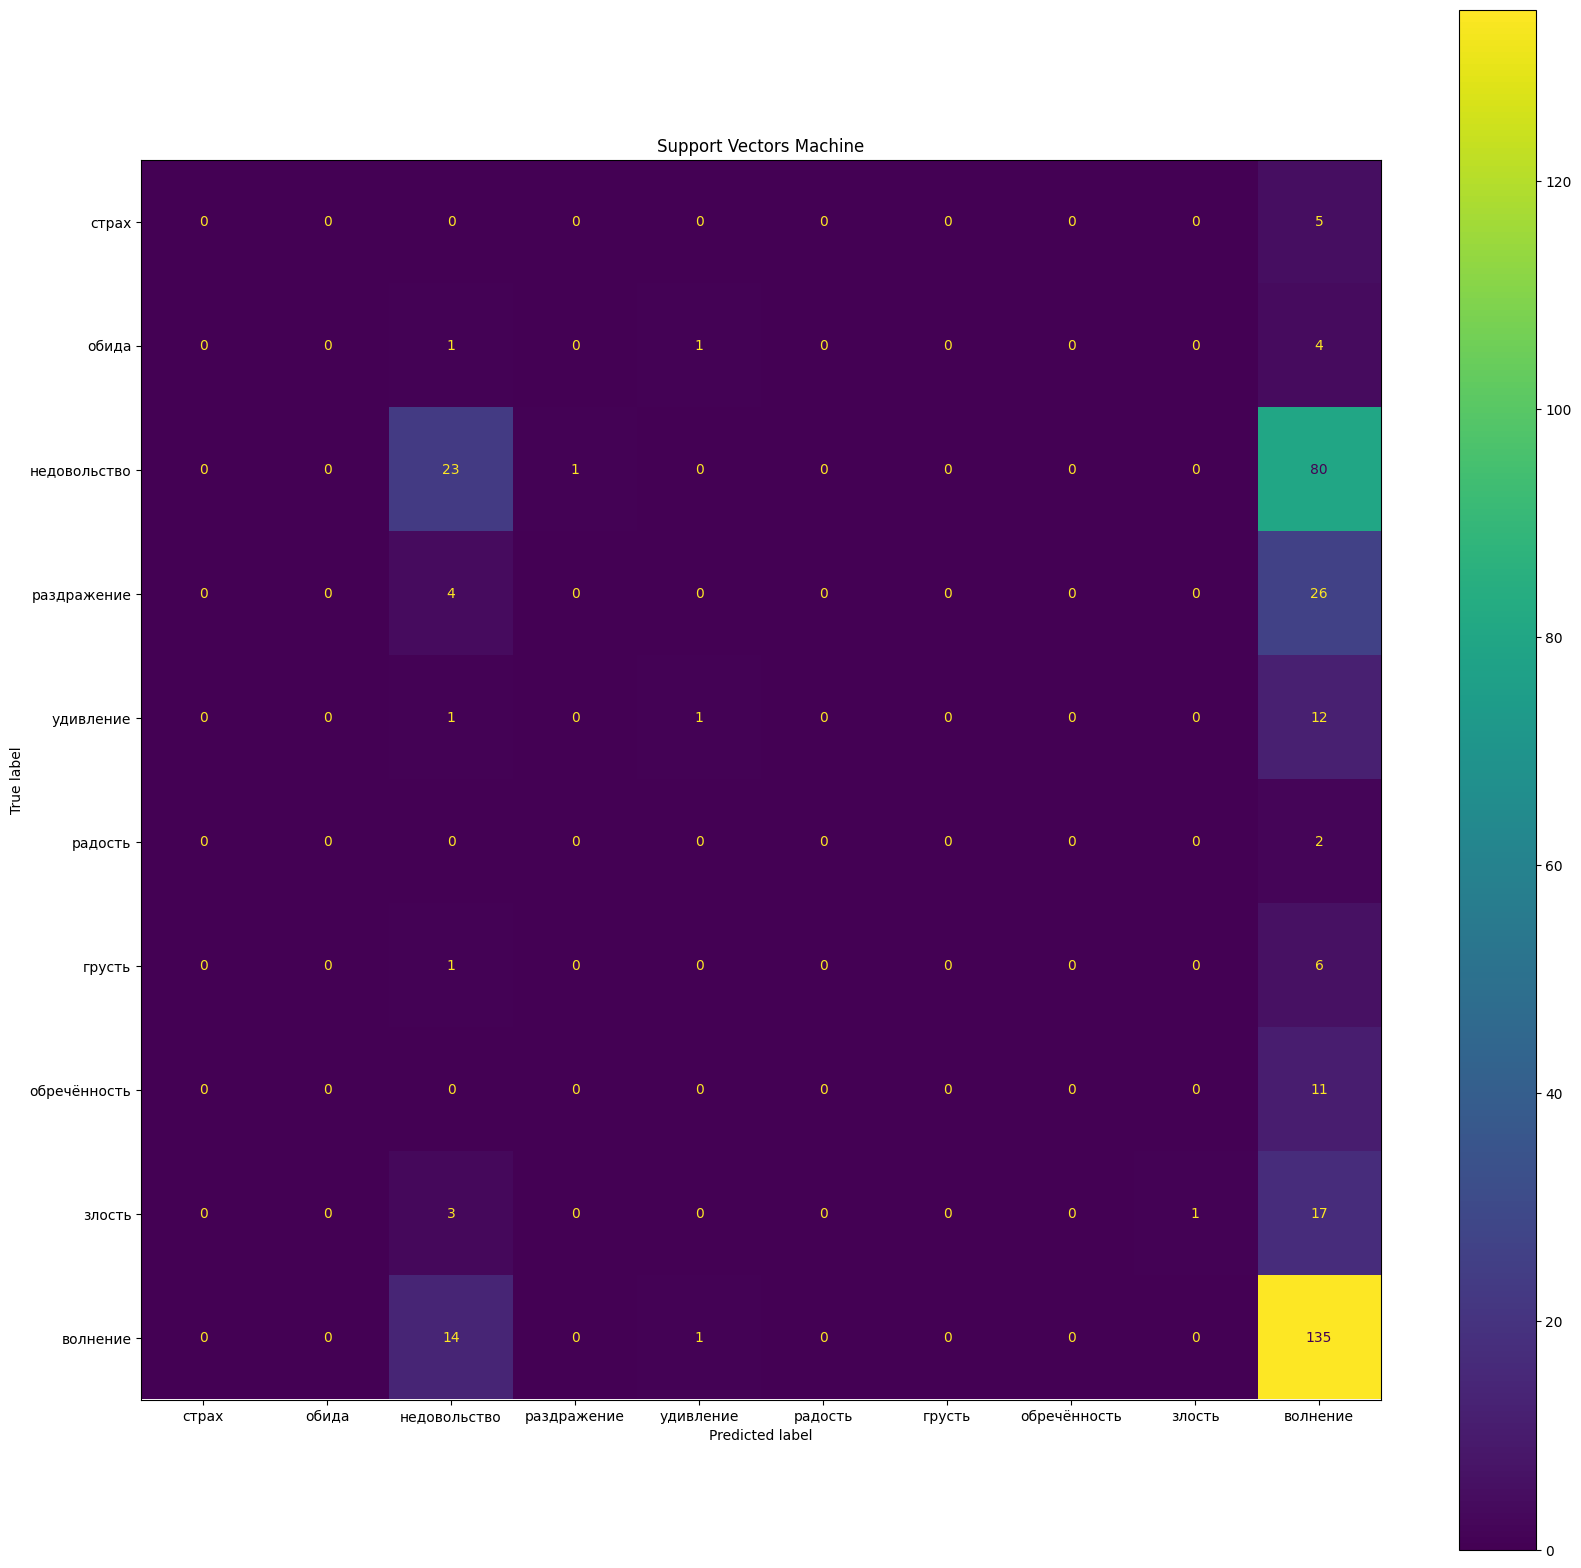

In [149]:
show_conf_matrx(y_test, svm.predict(X_test), svm.classes_, "Support Vectors Machine")

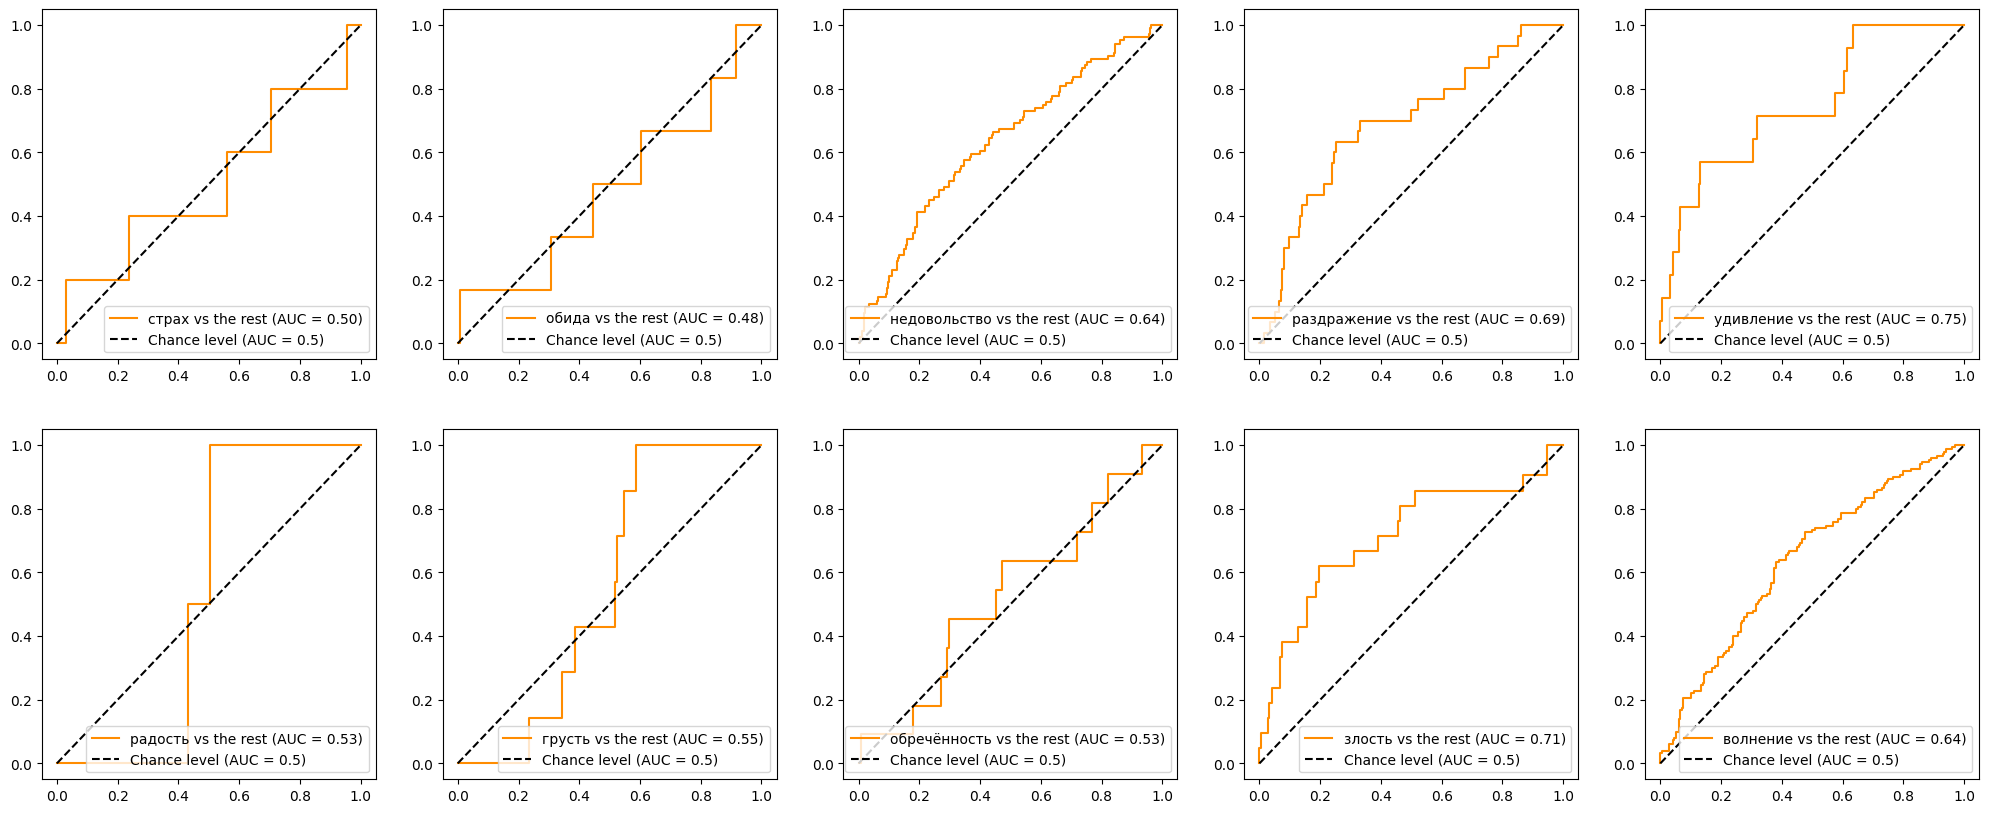

In [150]:
show_roc_curves(y_train, y_test, svm.predict_proba(X_test), svm.classes_)

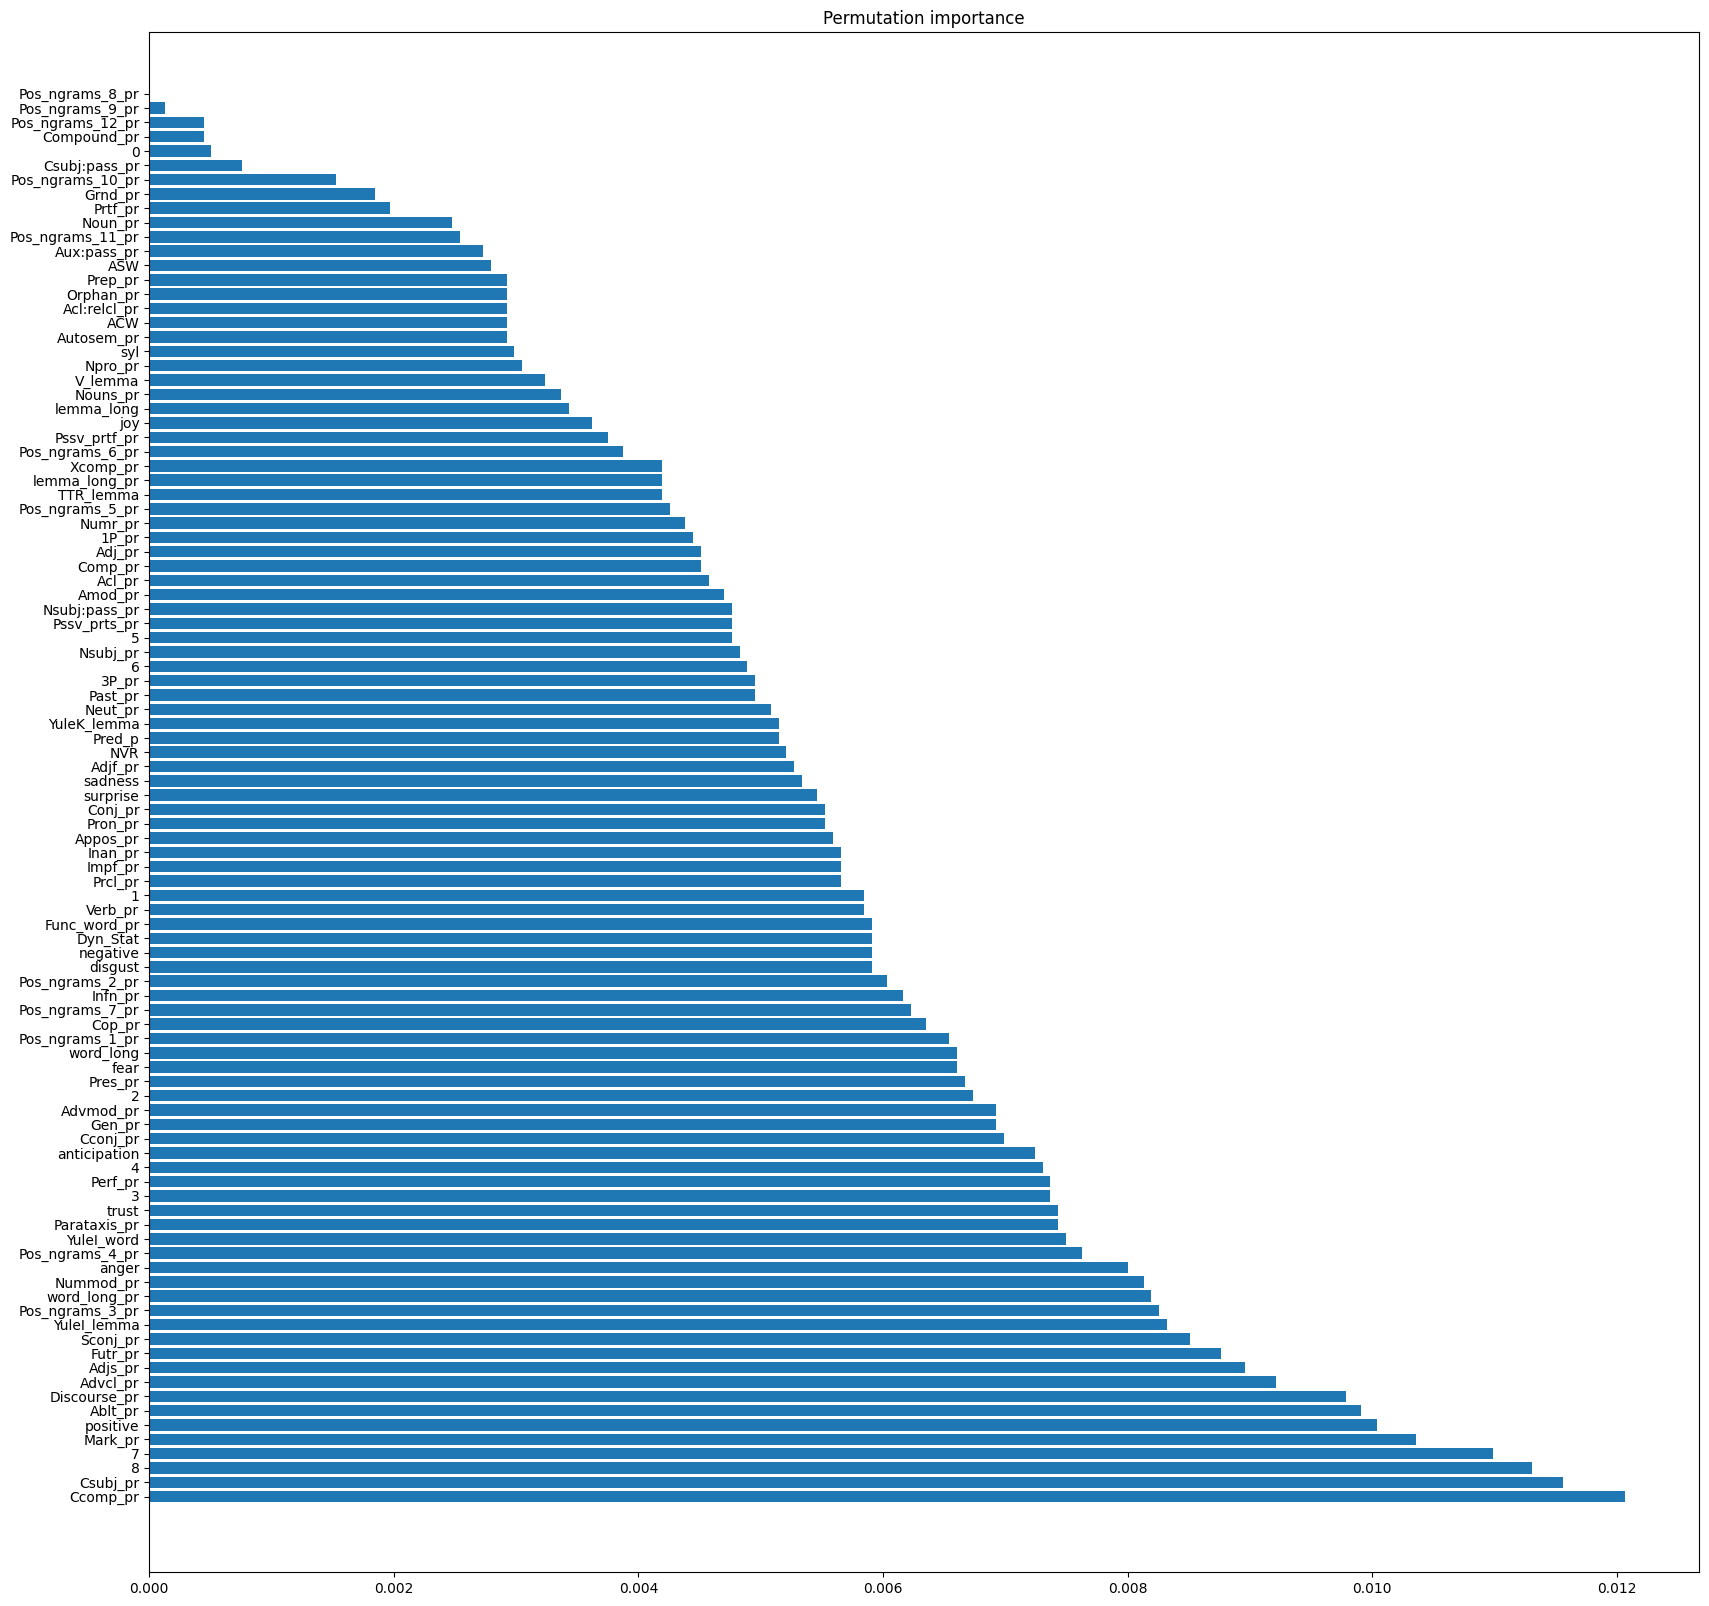

In [151]:
perm_imp_svm = permutation_importance(svm, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_svm.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## AdaBoost

In [ ]:
ada = AdaBoostClassifier()
ada.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(ada.predict(X_test), y_test, ada.predict_proba(X_test))
print("\nTrain:")
print_metrics(ada.predict(X_train), y_train, ada.predict_proba(X_train))

Test:
MSE: 20.92
Accuracy: 0.4342857142857143
F-score: 0.2707572665429808
ROC-AUC: 0.5015985574698353

Train:
MSE: 17.92090216010165
Accuracy: 0.4936467598475222
F-score: 0.335520073930852
ROC-AUC: 0.6237637985666853
